# Blood-Brain Barrier Permeability Prediction
## Traditional Machine Learning Methods

This notebook uses various traditional ML approaches for predicting BBB permeability using the B3DB_classification dataset.

### Experiments:
1. **Logistic Regression** with different feature representations
2. **Random Forest** with hyperparameter tuning
3. **XGBoost** classifier
4. **Ensemble Methods**
5. **Class Imbalance Handling** comparisons [SMOTE,class weighting]
6. **PCA-based Feature Selection**

### Features:
- Molecular Descriptors (RDKit)
- MACCS Fingerprints
- Morgan Fingerprints
- Combined features

## 1. Import Required Libraries

In [49]:
# Data manipulation
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# RDKit for molecular features
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Crippen, AllChem, MACCSkeys, rdFingerprintGenerator

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score, roc_auc_score)

# XGBoost
import xgboost as xgb

# Imbalanced-learn for class imbalance
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Explore Dataset

In [50]:
# Load B3DB classification dataset
df = pd.read_csv('../data/B3DB_classification.tsv', sep='\t')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nClass distribution:")
print(df['BBB+/BBB-'].value_counts())
print(f"\nClass proportions:")
print(df['BBB+/BBB-'].value_counts(normalize=True))

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

Dataset shape: (7807, 12)

First few rows:
   NO.                        compound_name  \
0    1                       sulphasalazine   
1    2                           moxalactam   
2    3                           clioquinol   
3    4  bbcpd11 (cimetidine analog) (y-g13)   
4    5                        schembl614298   

                                          IUPAC_name  \
0  2-hydroxy-5-[[4-(pyridin-2-ylsulfamoyl)phenyl]...   
1  7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...   
2                       5-chloro-7-iodoquinolin-8-ol   
3  2-[2-[(3-bromopyridin-2-yl)methylsulfanyl]ethy...   
4  (2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...   

                                              SMILES         CID  logBB  \
0   O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O      5339.0  -2.69   
1  COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...      3889.0  -2.52   
2                             Oc1c(I)cc(Cl)c2cccnc12      2788.0  -2.40   
3                         CCNC(=NCCSC

## 3. Feature Extraction

We'll extract three types of molecular features:
1. **Molecular Descriptors** - physico-chemical properties (MW, LogP, TPSA, etc.)
2. **MACCS Keys** - 166-bit structural fingerprints [each bit has fixed meaning]
3. **Morgan Fingerprints** - circular fingerprints (2048-bit) [substructures are hashed to get bit no]

In [51]:
### 3.1 Molecular Descriptors
def calculate_molecular_descriptors(smiles):
    """Calculate molecular descriptors from SMILES"""
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        return None
    
    descriptors = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Crippen.MolLogP(mol),
        'NumHDonors': Lipinski.NumHDonors(mol),
        'NumHAcceptors': Lipinski.NumHAcceptors(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumRotatableBonds': Lipinski.NumRotatableBonds(mol),
        'NumAromaticRings': Lipinski.NumAromaticRings(mol),
        'NumHeteroatoms': Lipinski.NumHeteroatoms(mol),
        'NumRings': Lipinski.RingCount(mol),
        'FractionCsp3': Lipinski.FractionCSP3(mol),
        'NumSaturatedRings': Lipinski.NumSaturatedRings(mol),
        'NumAliphaticRings': Lipinski.NumAliphaticRings(mol),
    }
    
    return descriptors

# Calculate descriptors for all molecules
descriptor_list = []
valid_indices = []

for idx, smiles in enumerate(df['SMILES']):
    desc = calculate_molecular_descriptors(smiles)
    if desc is not None:
        descriptor_list.append(desc)
        valid_indices.append(idx)

descriptors_df = pd.DataFrame(descriptor_list)
print(f"Molecular descriptors shape: {descriptors_df.shape}")
print(f"Valid molecules: {len(valid_indices)}/{len(df)}")
print(f"\nDescriptor statistics:")
print(descriptors_df.describe())

[21:36:33] Explicit valence for atom # 10 C, 4, is greater than permitted


Molecular descriptors shape: (7805, 12)
Valid molecules: 7805/7807

Descriptor statistics:
             MolWt         LogP   NumHDonors  NumHAcceptors         TPSA  \
count  7805.000000  7805.000000  7805.000000    7805.000000  7805.000000   
mean    385.458917     2.355938     2.010250       5.418962    87.009775   
std     170.887422     2.195739     2.262705       3.696626    67.689087   
min       6.941000    -8.895300     0.000000       0.000000     0.000000   
25%     285.343000     1.202100     1.000000       3.000000    41.490000   
50%     362.466000     2.547800     1.000000       4.000000    72.680000   
75%     451.607000     3.786400     3.000000       7.000000   107.610000   
max    1882.332000    12.605800    24.000000      33.000000   662.410000   

       NumRotatableBonds  NumAromaticRings  NumHeteroatoms     NumRings  \
count        7805.000000       7805.000000     7805.000000  7805.000000   
mean            4.770788          1.318258        7.034721     3.267521   

[21:36:35] Explicit valence for atom # 10 C, 4, is greater than permitted


In [52]:
### 3.2 MACCS Fingerprints
def calculate_maccs_fingerprints(smiles):
    """Calculate MACCS keys fingerprints"""
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        return None
    
    maccs = MACCSkeys.GenMACCSKeys(mol)
    return np.array(maccs)

maccs_list = []

for idx in valid_indices:
    smiles = df.iloc[idx]['SMILES']
    maccs = calculate_maccs_fingerprints(smiles)
    if maccs is not None:
        maccs_list.append(maccs)

maccs_df = pd.DataFrame(maccs_list, columns=[f'MACCS_{i}' for i in range(len(maccs_list[0]))])
print(f"MACCS fingerprints shape: {maccs_df.shape}")

MACCS fingerprints shape: (7805, 167)


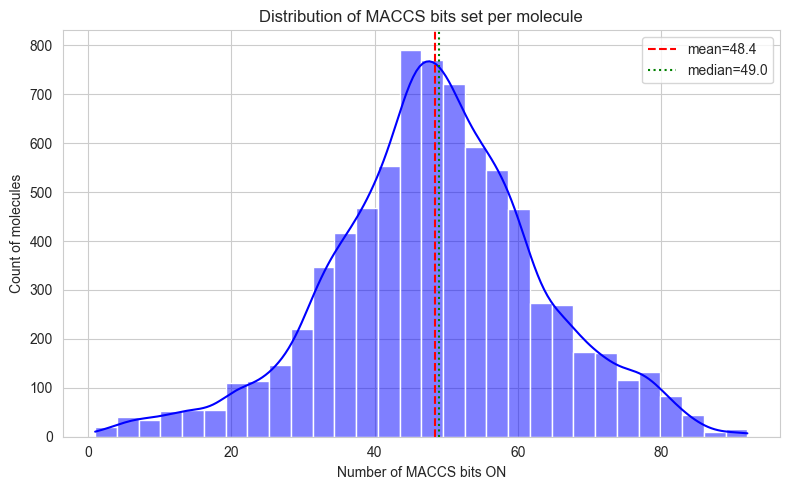

In [53]:
# Count bits set per molecule
maccs_bits_per_mol = maccs_df.sum(axis=1)

# Plot
plt.figure(figsize=(8,5))
sns.histplot(maccs_bits_per_mol, bins=30, kde=True, color='blue')
mean_val = maccs_bits_per_mol.mean()
median_val = maccs_bits_per_mol.median()
plt.axvline(mean_val, color='red', linestyle='--', label=f"mean={mean_val:.1f}")
plt.axvline(median_val, color='green', linestyle=':', label=f"median={median_val:.1f}")
plt.xlabel('Number of MACCS bits ON')
plt.ylabel('Count of molecules')
plt.title('Distribution of MACCS bits set per molecule')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/ml_methods/maccs_bit_count_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Hence, on average 48-50 bits out of 166 bits are turned on in maccs fingerprints of molecules in dataset.

In [54]:
### 3.3 Morgan Fingerprints
def calculate_morgan_fingerprints(smiles, generator):
    """Calculate Morgan (circular) fingerprints"""
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        return None
    morgan = generator.GetFingerprint(mol)
    return np.array(morgan)


morgan_list = []
gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=512)
for idx in valid_indices:
    smiles = df.iloc[idx]['SMILES']
    morgan = calculate_morgan_fingerprints(smiles,gen)
    if morgan is not None:
        morgan_list.append(morgan)

morgan_df = pd.DataFrame(morgan_list, columns=[f'Morgan_{i}' for i in range(len(morgan_list[0]))])
print(f"Morgan fingerprints shape: {morgan_df.shape}")

Morgan fingerprints shape: (7805, 512)


Here, I experimented with fingerprint sizes of 256,512 and 2048. Fingerprint size of 512 seems to give best results as it is not too sparse(like 2048 size fingerprint) and can carry more information(less collisions, like 256 size fingerprint).

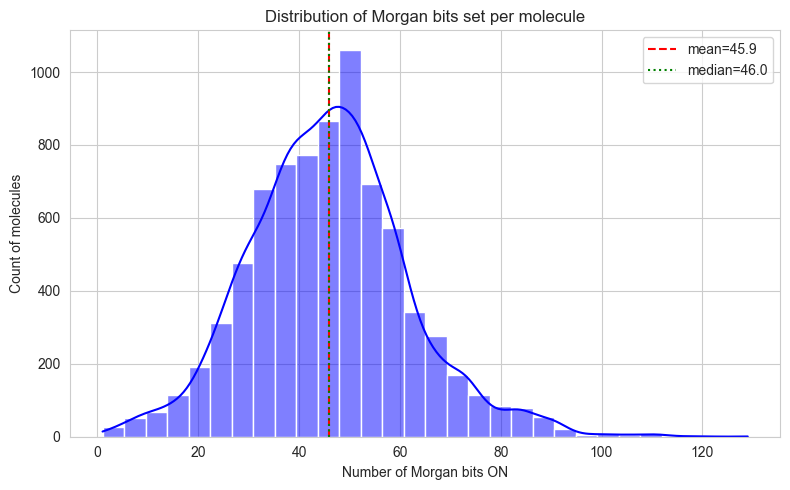

In [55]:
# Count bits set per molecule
morgan_bits_per_mol = morgan_df.sum(axis=1)

# Plot
plt.figure(figsize=(8,5))
sns.histplot(morgan_bits_per_mol, bins=30, kde=True, color='blue')
mean_val = morgan_bits_per_mol.mean()
median_val = morgan_bits_per_mol.median()
plt.axvline(mean_val, color='red', linestyle='--', label=f"mean={mean_val:.1f}")
plt.axvline(median_val, color='green', linestyle=':', label=f"median={median_val:.1f}")
plt.xlabel('Number of Morgan bits ON')
plt.ylabel('Count of molecules')
plt.title('Distribution of Morgan bits set per molecule')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/ml_methods/morgan_bit_count_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Hence, on average 44 morgan bits are turned on out of 512 bits, making morgan bits more sparse.

In [56]:
### 3.4 Combine Features and Prepare Labels
# Get labels for valid molecules
y = df.iloc[valid_indices]['BBB+/BBB-'].values

# Convert labels to binary (BBB+ = 1, BBB- = 0)
y_binary = (y == 'BBB+').astype(int)

# Create combined feature sets
X_descriptors = descriptors_df.values
X_maccs = maccs_df.values
X_morgan = morgan_df.values
X_desc_maccs = np.hstack([X_descriptors, X_maccs])
X_desc_morgan = np.hstack([X_descriptors, X_morgan])
X_all = np.hstack([X_descriptors, X_maccs, X_morgan])

print(f"Feature set shapes:")
print(f"  Descriptors only: {X_descriptors.shape}")
print(f"  MACCS only: {X_maccs.shape}")
print(f"  Morgan only: {X_morgan.shape}")
print(f"  Descriptors + MACCS: {X_desc_maccs.shape}")
print(f"  Descriptors + Morgan: {X_desc_morgan.shape}")
print(f"  All features: {X_all.shape}")
print(f"\nLabels shape: {y_binary.shape}")
print(f"Class distribution: BBB+ = {np.sum(y_binary)}, BBB- = {len(y_binary) - np.sum(y_binary)}")

Feature set shapes:
  Descriptors only: (7805, 12)
  MACCS only: (7805, 167)
  Morgan only: (7805, 512)
  Descriptors + MACCS: (7805, 179)
  Descriptors + Morgan: (7805, 524)
  All features: (7805, 691)

Labels shape: (7805,)
Class distribution: BBB+ = 4956, BBB- = 2849


## 4. Evaluation Functions

Functions to calculate metrics and create visualizations

In [57]:
def evaluate_model(model, X_train, X_eval, y_train, y_eval, model_name="Model", eval_set_name="Validation"):
    """
    Comprehensive model evaluation with all required metrics
    
    Args:
        model: The model to train and evaluate
        X_train: Training features
        X_eval: Evaluation features (validation or test)
        y_train: Training labels
        y_eval: Evaluation labels (validation or test)
        model_name: Name of the model for display
        eval_set_name: Name of evaluation set ("Validation" or "Test")
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_eval)
    y_pred_proba = model.predict_proba(X_eval)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_eval, y_pred)
    
    # Class-wise precision, recall, f1
    precision_per_class = precision_score(y_eval, y_pred, average=None)
    recall_per_class = recall_score(y_eval, y_pred, average=None)
    f1_per_class = f1_score(y_eval, y_pred, average=None)
    
    # Overall metrics
    precision_macro = precision_score(y_eval, y_pred, average='macro')
    precision_weighted = precision_score(y_eval, y_pred, average='weighted')
    recall_macro = recall_score(y_eval, y_pred, average='macro')
    recall_weighted = recall_score(y_eval, y_pred, average='weighted')
    f1_macro = f1_score(y_eval, y_pred, average='macro')
    f1_weighted = f1_score(y_eval, y_pred, average='weighted')
    
    # ROC AUC
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_eval, y_pred_proba)
        avg_precision = average_precision_score(y_eval, y_pred_proba)
    else:
        roc_auc = None
        avg_precision = None
    
    print(f"\n{model_name} - {eval_set_name} Set Results")
    print(f"="*70)
    print(f"\nOverall Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"\nPrecision:")
    print(f"  BBB- (Class 0): {precision_per_class[0]:.4f}")
    print(f"  BBB+ (Class 1): {precision_per_class[1]:.4f}")
    print(f"  Macro Average: {precision_macro:.4f}")
    print(f"  Weighted Average: {precision_weighted:.4f}")
    print(f"\nRecall:")
    print(f"  BBB- (Class 0): {recall_per_class[0]:.4f}")
    print(f"  BBB+ (Class 1): {recall_per_class[1]:.4f}")
    print(f"  Macro Average: {recall_macro:.4f}")
    print(f"  Weighted Average: {recall_weighted:.4f}")
    print(f"\nF1-Score:")
    print(f"  BBB- (Class 0): {f1_per_class[0]:.4f}")
    print(f"  BBB+ (Class 1): {f1_per_class[1]:.4f}")
    print(f"  Macro Average: {f1_macro:.4f}")
    print(f"  Weighted Average: {f1_weighted:.4f}")
    
    if roc_auc is not None:
        print(f"\nROC AUC Score: {roc_auc:.4f}")
        print(f"Average Precision Score: {avg_precision:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_eval, y_pred, target_names=['BBB-', 'BBB+']))
    
    # Store results
    results = {
        'model_name': model_name,
        'eval_set': eval_set_name,
        'accuracy': accuracy,
        'precision_class_0': precision_per_class[0],
        'precision_class_1': precision_per_class[1],
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_class_0': recall_per_class[0],
        'recall_class_1': recall_per_class[1],
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_class_0': f1_per_class[0],
        'f1_class_1': f1_per_class[1],
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'y_eval': y_eval,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'model': model  # Store fitted model for later use
    }
    
    return results

In [58]:
def plot_roc_curve(results_list, title="ROC Curves"):
    """
    Plot ROC curves for multiple models
    """
    plt.figure(figsize=(10, 8))
    
    for results in results_list:
        if results['y_pred_proba'] is not None:
            fpr, tpr, _ = roc_curve(results['y_eval'], results['y_pred_proba'])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f"{results['model_name']} (AUC = {roc_auc:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_precision_recall_curve(results_list, title="Precision-Recall Curves"):
    """
    Plot Precision-Recall curves for multiple models
    """
    plt.figure(figsize=(10, 8))
    
    for results in results_list:
        if results['y_pred_proba'] is not None:
            precision, recall, _ = precision_recall_curve(results['y_eval'], results['y_pred_proba'])
            avg_precision = average_precision_score(results['y_eval'], results['y_pred_proba'])
            plt.plot(recall, precision, lw=2, label=f"{results['model_name']} (AP = {avg_precision:.3f})")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_eval, y_pred, model_name="Model"):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_eval, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['BBB-', 'BBB+'], 
                yticklabels=['BBB-', 'BBB+'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

## 5. Train-Validation-Test Split

Split data into training, validation, and testing sets:
- **Test set**: 20% of total data (held out for final evaluation only)
- **Training set**: 64% of total data (80% of remaining 80%)
- **Validation set**: 16% of total data (20% of remaining 80%)

The validation set will be used for:
- Hyperparameter tuning
- Model selection
- Choosing ideal input representations

The test set will only be used for final performance reporting.

Using stratified sampling with random_state=42.

In [59]:
# We'll store results for all experiments
all_results = []

# Set random seed for reproducibility
RANDOM_STATE = 42

splits = {}

for name, X in [('descriptors', X_descriptors), 
                ('maccs', X_maccs), 
                ('morgan', X_morgan),
                ('desc_maccs', X_desc_maccs),
                ('desc_morgan', X_desc_morgan),
                ('all', X_all)]:
    
    # First split: separate test set (20%)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y_binary, test_size=0.2, random_state=RANDOM_STATE, stratify=y_binary
    )
    
    # Second split: split remaining into train (80%) and val (20%)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.2, random_state=RANDOM_STATE, stratify=y_temp
    )
    
    # Scale features using training set statistics only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    splits[name] = {
        'X_train': X_train_scaled,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'scaler': scaler
    }
    
    print(f"{name}: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

print(f"\nDataset split sizes:")
print(f"  Training: {len(y_train)} samples ({len(y_train)/len(y_binary)*100:.1f}%)")
print(f"  Validation: {len(y_val)} samples ({len(y_val)/len(y_binary)*100:.1f}%)")
print(f"  Test: {len(y_test)} samples ({len(y_test)/len(y_binary)*100:.1f}%)")
print(f"\nClass distribution:")
print(f"  Train - BBB+: {sum(y_train)}, BBB-: {len(y_train)-sum(y_train)}")
print(f"  Val - BBB+: {sum(y_val)}, BBB-: {len(y_val)-sum(y_val)}")
print(f"  Test - BBB+: {sum(y_test)}, BBB-: {len(y_test)-sum(y_test)}")

descriptors: Train=(4995, 12), Val=(1249, 12), Test=(1561, 12)
maccs: Train=(4995, 167), Val=(1249, 167), Test=(1561, 167)
morgan: Train=(4995, 512), Val=(1249, 512), Test=(1561, 512)
desc_maccs: Train=(4995, 179), Val=(1249, 179), Test=(1561, 179)
desc_morgan: Train=(4995, 524), Val=(1249, 524), Test=(1561, 524)
all: Train=(4995, 691), Val=(1249, 691), Test=(1561, 691)

Dataset split sizes:
  Training: 4995 samples (64.0%)
  Validation: 1249 samples (16.0%)
  Test: 1561 samples (20.0%)

Class distribution:
  Train - BBB+: 3172, BBB-: 1823
  Val - BBB+: 793, BBB-: 456
  Test - BBB+: 991, BBB-: 570


## 6. Logistic Regression Experiments

### 6.1 Without Class Imbalance Handling

Testing with different feature representations

In [60]:
# Logistic Regression without class imbalance handling
lr_results_no_balance = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_maccs','desc_morgan', 'all']:
    split = splits[feature_name]
    
    lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    
    results = evaluate_model(
        lr_model,
        split['X_train'], split['X_val'],
        split['y_train'], split['y_val'],
        model_name=f"LR - {feature_name} (No Balance)",
        eval_set_name="Validation"
    )
    
    lr_results_no_balance.append(results)
    all_results.append(results)


LR - descriptors (No Balance) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8022

Precision:
  BBB- (Class 0): 0.8196
  BBB+ (Class 1): 0.7961
  Macro Average: 0.8078
  Weighted Average: 0.8047

Recall:
  BBB- (Class 0): 0.5877
  BBB+ (Class 1): 0.9256
  Macro Average: 0.7567
  Weighted Average: 0.8022

F1-Score:
  BBB- (Class 0): 0.6845
  BBB+ (Class 1): 0.8560
  Macro Average: 0.7703
  Weighted Average: 0.7934

ROC AUC Score: 0.8492
Average Precision Score: 0.8765

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.82      0.59      0.68       456
        BBB+       0.80      0.93      0.86       793

    accuracy                           0.80      1249
   macro avg       0.81      0.76      0.77      1249
weighted avg       0.80      0.80      0.79      1249


LR - maccs (No Balance) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8287

Precision:
  BBB- (Class 0): 0.8218
  BBB+ (Class 1): 0.8316
  Macro Average: 

### Some Observations : 

- Due to class imbalance towards positive samples in dataset, performance on BBB- is generally worse than for BBB+, with recall being affected more.Example , for logistic regression model using just descriptors, classification report is as follows : 


    Classification Report:


                precision    recall  f1-score   support

            BBB-       0.81      0.62      0.70       570
            BBB+       0.81      0.91      0.86       991


    Notice, how even though precision for both classes are similar, recall is way worse for BBB- than BBB+.

- Using descriptors along with fingerprints leads to some improvement in AUC score eg. morgan (AUC = 0.913) vs desc + morgan (AUC = 0.920)

- Morgan fingerprints generally seem to perform better than maccs fingerprint - this could be because they are longer and more flexible (fixed substructures vs any substructure).

- Concatenation of all input representations (descriptors + morgan fp + maccs fp) seems to perform best. (AUC = 0.928)

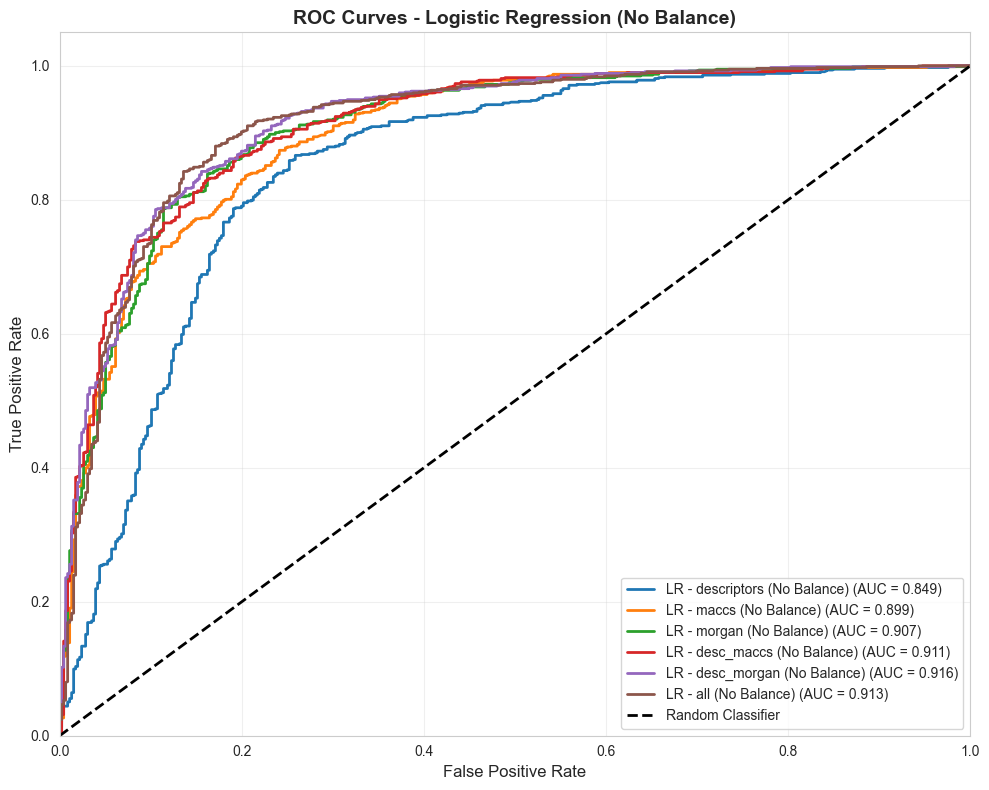

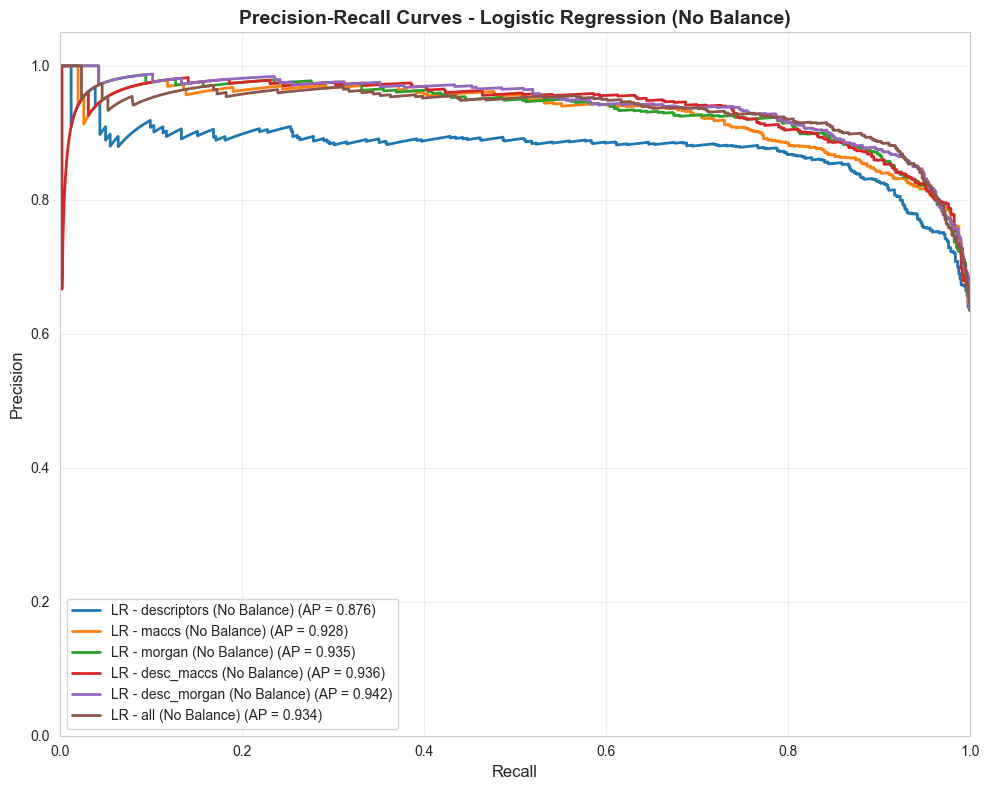

In [61]:
# Plot ROC and PR curves for LR without balance
plot_roc_curve(lr_results_no_balance, title="ROC Curves - Logistic Regression (No Balance)")
plot_precision_recall_curve(lr_results_no_balance, title="Precision-Recall Curves - Logistic Regression (No Balance)")

### 6.2 With Class Imbalance Handling (SMOTE)

Using SMOTE to balance the training data

In [62]:
# Logistic Regression with SMOTE
lr_results_smote = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_morgan','desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Apply SMOTE to training data
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_balanced, y_train_balanced = smote.fit_resample(split['X_train'], split['y_train'])
    
    print(f"\n{feature_name}: Original train size: {len(split['y_train'])}, Balanced: {len(y_train_balanced)}")
    print(f"Class distribution after SMOTE: {np.bincount(y_train_balanced)}")
    
    lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    lr_model.fit(X_train_balanced, y_train_balanced)
    
    y_pred = lr_model.predict(split['X_val'])
    y_pred_proba = lr_model.predict_proba(split['X_val'])[:, 1]
    
    results = evaluate_model(
        lr_model,
        X_train_balanced, split['X_val'],
        y_train_balanced, split['y_val'],
        model_name=f"LR - {feature_name} (SMOTE)",
        eval_set_name="Validation"
    )
    
    lr_results_smote.append(results)
    all_results.append(results)


descriptors: Original train size: 4995, Balanced: 6344
Class distribution after SMOTE: [3172 3172]

LR - descriptors (SMOTE) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8183

Precision:
  BBB- (Class 0): 0.7550
  BBB+ (Class 1): 0.8538
  Macro Average: 0.8044
  Weighted Average: 0.8177

Recall:
  BBB- (Class 0): 0.7434
  BBB+ (Class 1): 0.8613
  Macro Average: 0.8024
  Weighted Average: 0.8183

F1-Score:
  BBB- (Class 0): 0.7492
  BBB+ (Class 1): 0.8575
  Macro Average: 0.8033
  Weighted Average: 0.8180

ROC AUC Score: 0.8507
Average Precision Score: 0.8815

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.76      0.74      0.75       456
        BBB+       0.85      0.86      0.86       793

    accuracy                           0.82      1249
   macro avg       0.80      0.80      0.80      1249
weighted avg       0.82      0.82      0.82      1249


maccs: Original train size: 4995, Balanced: 6344
Class distribution af


LR - maccs (SMOTE) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8351

Precision:
  BBB- (Class 0): 0.7753
  BBB+ (Class 1): 0.8692
  Macro Average: 0.8223
  Weighted Average: 0.8349

Recall:
  BBB- (Class 0): 0.7719
  BBB+ (Class 1): 0.8714
  Macro Average: 0.8217
  Weighted Average: 0.8351

F1-Score:
  BBB- (Class 0): 0.7736
  BBB+ (Class 1): 0.8703
  Macro Average: 0.8220
  Weighted Average: 0.8350

ROC AUC Score: 0.9021
Average Precision Score: 0.9315

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.78      0.77      0.77       456
        BBB+       0.87      0.87      0.87       793

    accuracy                           0.84      1249
   macro avg       0.82      0.82      0.82      1249
weighted avg       0.83      0.84      0.83      1249


morgan: Original train size: 4995, Balanced: 6344
Class distribution after SMOTE: [3172 3172]

LR - morgan (SMOTE) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8455

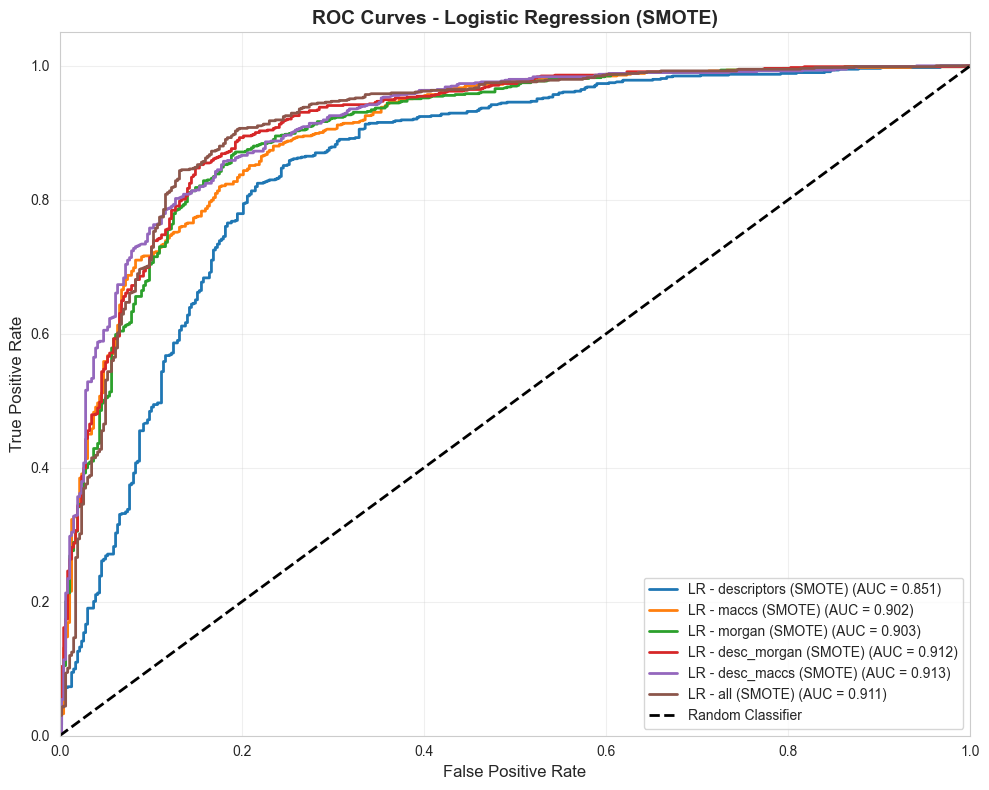

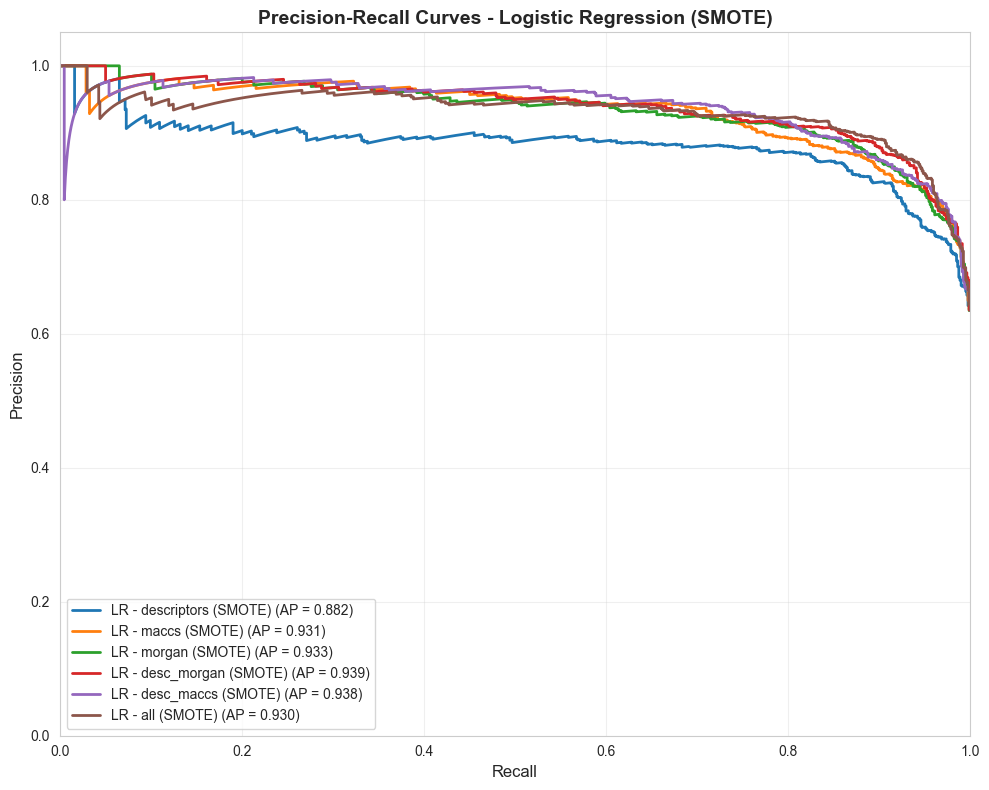

In [63]:
# Plot ROC and PR curves for LR with SMOTE
plot_roc_curve(lr_results_smote, title="ROC Curves - Logistic Regression (SMOTE)")
plot_precision_recall_curve(lr_results_smote, title="Precision-Recall Curves - Logistic Regression (SMOTE)")

### Effects of SMOTE : 
- SMOTE doesn't help performance much , even though dataset is balanced now.
- SMOTE improves recall of BBB- class, but doesn't improve accuracy and AUC overall as precision of BBB- class decreases due to SMOTE. 
- This can be explained by the fact that SMOTE doesn't work very well with high dimensional,sparse data [like our fingerprints].

### 6.4 Logistic Regression with Class Weighting

Using class_weight='balanced' (and explicit computed class weights) to handle imbalance without resampling. We'll train and evaluate Logistic Regression across the same feature sets and compare ROC / PR curves.


descriptors class weights: {0: np.float64(1.3699945145364782), 1: np.float64(0.787358133669609)}

LR - descriptors (ClassWeight) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8167

Precision:
  BBB- (Class 0): 0.7551
  BBB+ (Class 1): 0.8507
  Macro Average: 0.8029
  Weighted Average: 0.8158

Recall:
  BBB- (Class 0): 0.7368
  BBB+ (Class 1): 0.8625
  Macro Average: 0.7997
  Weighted Average: 0.8167

F1-Score:
  BBB- (Class 0): 0.7458
  BBB+ (Class 1): 0.8566
  Macro Average: 0.8012
  Weighted Average: 0.8162

ROC AUC Score: 0.8512
Average Precision Score: 0.8805

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.76      0.74      0.75       456
        BBB+       0.85      0.86      0.86       793

    accuracy                           0.82      1249
   macro avg       0.80      0.80      0.80      1249
weighted avg       0.82      0.82      0.82      1249


maccs class weights: {0: np.float64(1.3699945145364782), 1: np.flo


LR - maccs (ClassWeight) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8279

Precision:
  BBB- (Class 0): 0.7591
  BBB+ (Class 1): 0.8686
  Macro Average: 0.8139
  Weighted Average: 0.8287

Recall:
  BBB- (Class 0): 0.7741
  BBB+ (Class 1): 0.8588
  Macro Average: 0.8164
  Weighted Average: 0.8279

F1-Score:
  BBB- (Class 0): 0.7666
  BBB+ (Class 1): 0.8637
  Macro Average: 0.8151
  Weighted Average: 0.8282

ROC AUC Score: 0.9006
Average Precision Score: 0.9306

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.76      0.77      0.77       456
        BBB+       0.87      0.86      0.86       793

    accuracy                           0.83      1249
   macro avg       0.81      0.82      0.82      1249
weighted avg       0.83      0.83      0.83      1249


morgan class weights: {0: np.float64(1.3699945145364782), 1: np.float64(0.787358133669609)}

LR - morgan (ClassWeight) - Validation Set Results

Overall Metrics:
  Accura

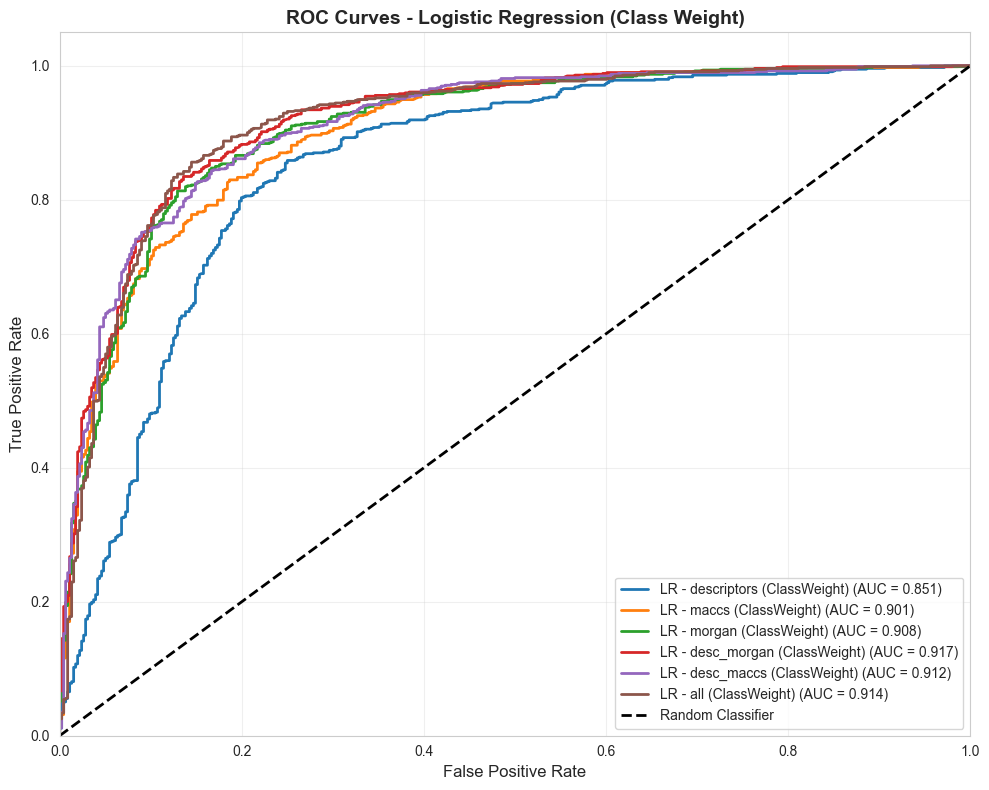

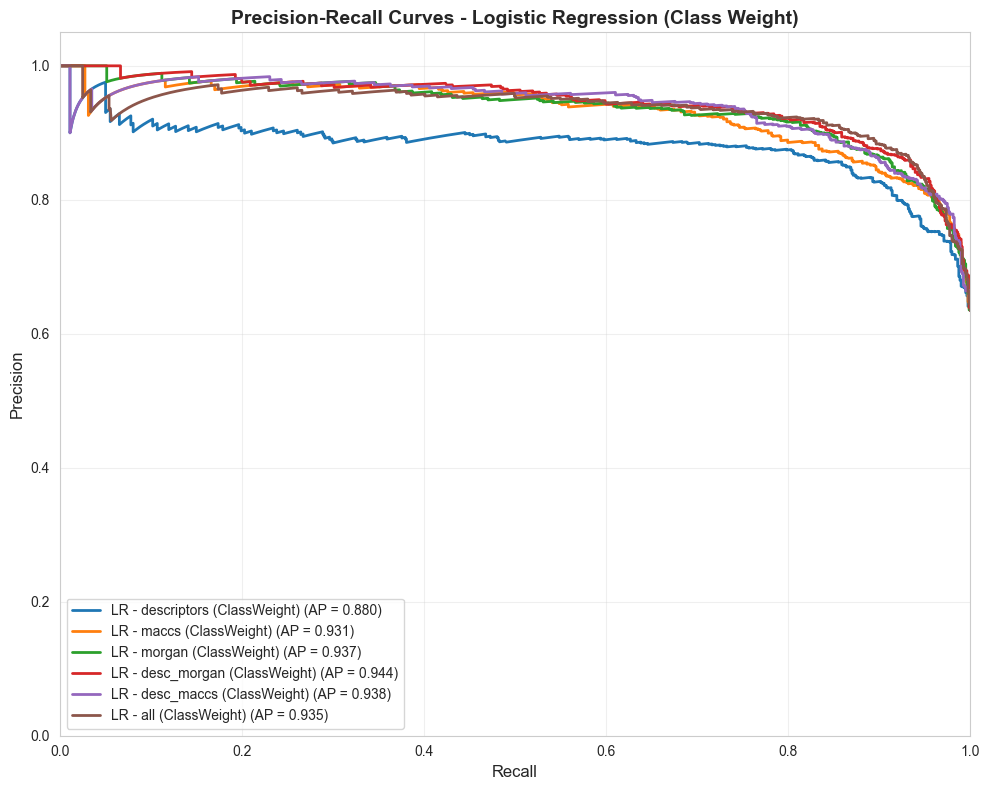

In [64]:
# Logistic Regression with class weighting
from sklearn.utils.class_weight import compute_class_weight

lr_results_class_weight = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_morgan','desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Compute class weights from training data
    classes = np.unique(split['y_train'])
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=split['y_train'])
    cw = {int(c): w for c, w in zip(classes, class_weights)}
    print(f"\n{feature_name} class weights: {cw}")
    
    # Train Logistic Regression with class_weight
    lr_model_cw = LogisticRegression(max_iter=1000, class_weight=cw, random_state=RANDOM_STATE)
    
    results = evaluate_model(
        lr_model_cw,
        split['X_train'], split['X_val'],
        split['y_train'], split['y_val'],
        model_name=f"LR - {feature_name} (ClassWeight)",
        eval_set_name="Validation"
    )
    
    lr_results_class_weight.append(results)
    all_results.append(results)

# Plot ROC and PR curves for class-weighted LR
plot_roc_curve(lr_results_class_weight, title="ROC Curves - Logistic Regression (Class Weight)")
plot_precision_recall_curve(lr_results_class_weight, title="Precision-Recall Curves - Logistic Regression (Class Weight)")

Similarly, we seee that weighting classes differently mostly leads to similar AUC.

This is because even though recall of minority class (BBB-) increases because of class weighting, precision of minority class(BBB-) decreases [as more molecules get classified as BBB-].

Hence , overall performance stays similar. [just like SMOTE]

### 6.3 Logistic Regression with PCA

Using PCA to reduce dimensionality and identify most important features

In [65]:
# Apply PCA to find optimal number of components (explaining 95% variance)
lr_results_pca = []

for feature_name in ['descriptors', 'maccs', 'morgan','desc_morgan','desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Apply PCA with 95% variance explained
    pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(split['X_train'])
    X_val_pca = pca.transform(split['X_val'])
    
    print(f"\n{feature_name}:")
    print(f"  Original dimensions: {split['X_train'].shape[1]}")
    print(f"  PCA components (95% variance): {X_train_pca.shape[1]}")
    print(f"  Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
    
    # Train Logistic Regression on PCA features
    lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    
    results = evaluate_model(
        lr_model,
        X_train_pca, X_val_pca,
        split['y_train'], split['y_val'],
        model_name=f"LR - {feature_name} (PCA 95%)",
        eval_set_name="Validation"
    )
    
    lr_results_pca.append(results)
    all_results.append(results)


descriptors:
  Original dimensions: 12
  PCA components (95% variance): 6
  Explained variance ratio: 0.9602

LR - descriptors (PCA 95%) - Validation Set Results

Overall Metrics:
  Accuracy: 0.7966

Precision:
  BBB- (Class 0): 0.8217
  BBB+ (Class 1): 0.7882
  Macro Average: 0.8049
  Weighted Average: 0.8004

Recall:
  BBB- (Class 0): 0.5658
  BBB+ (Class 1): 0.9294
  Macro Average: 0.7476
  Weighted Average: 0.7966

F1-Score:
  BBB- (Class 0): 0.6701
  BBB+ (Class 1): 0.8530
  Macro Average: 0.7616
  Weighted Average: 0.7862

ROC AUC Score: 0.8385
Average Precision Score: 0.8488

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.82      0.57      0.67       456
        BBB+       0.79      0.93      0.85       793

    accuracy                           0.80      1249
   macro avg       0.80      0.75      0.76      1249
weighted avg       0.80      0.80      0.79      1249


maccs:
  Original dimensions: 167
  PCA components (95% va

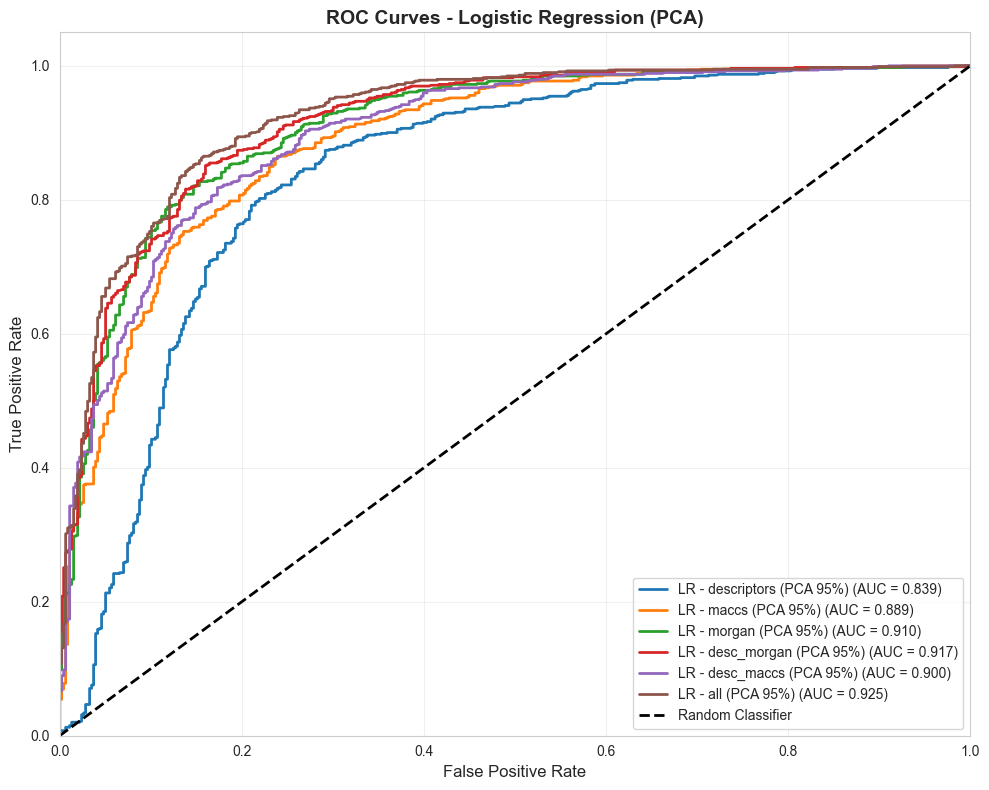

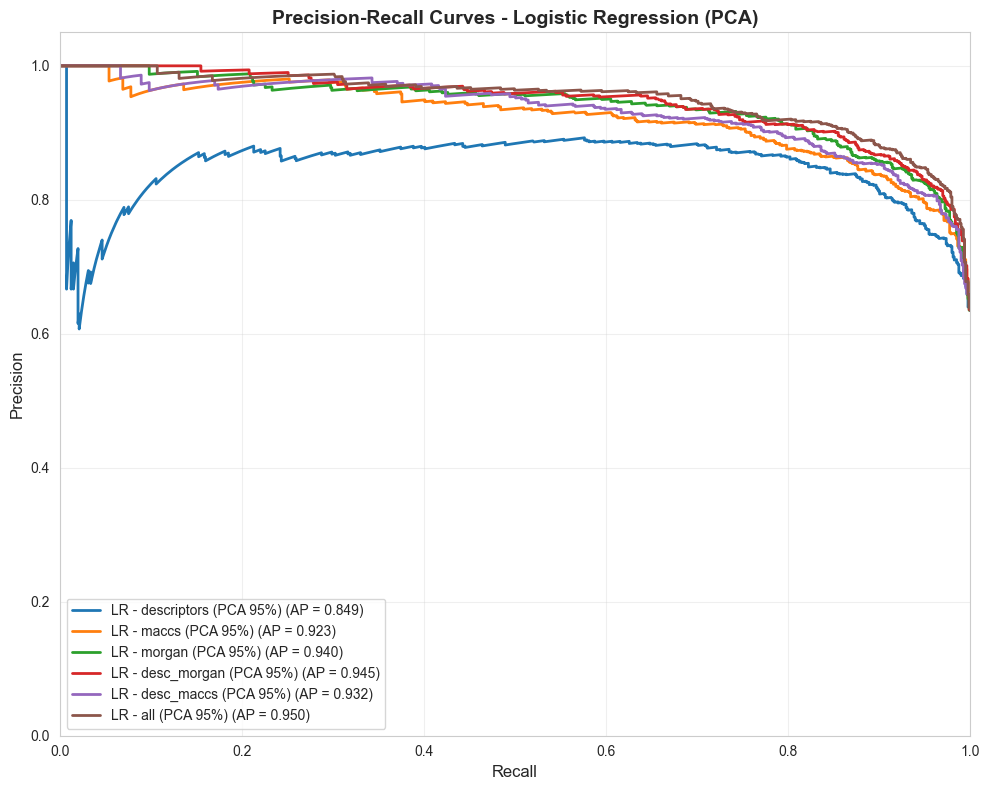

In [66]:
# Plot ROC and PR curves for LR with PCA
plot_roc_curve(lr_results_pca, title="ROC Curves - Logistic Regression (PCA)")
plot_precision_recall_curve(lr_results_pca, title="Precision-Recall Curves - Logistic Regression (PCA)")

### Some observations

- Using PCA leads to lower AUC for descriptors,maccs and desc_maccs. This could be because they are relatively low dimensional representations, and hence removing some dimensions leads to loss of information which leads to worst performance.

- However, it improves(or doesn't affect) performance for morgan,desc_morgan and all(morgan + maccs + descriptors). This could be because morgan fingerprints are comparatively high dimensional and sparse, and hence removing some of the extraneous dimensions helped improve performance of classifier.

## Best Model for Logistic Regression

**AUC = 0.932**

Input = Principal components explaining 95% variance after performing PCA on [morgan + maccs + descriptors]

## 7. Random Forest Experiments

### 7.1 Random Forest with Default Parameters (No Balance)

In [67]:
# Random Forest without class imbalance handling
rf_results_no_balance = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_morgan','desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Create and train model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    
    results = evaluate_model(
        rf_model,
        split['X_train'], split['X_val'],
        split['y_train'], split['y_val'],
        model_name=f"RF - {feature_name} (No Balance)",
        eval_set_name="Validation"
    )
    
    rf_results_no_balance.append(results)
    all_results.append(results)


RF - descriptors (No Balance) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8799

Precision:
  BBB- (Class 0): 0.8923
  BBB+ (Class 1): 0.8743
  Macro Average: 0.8833
  Weighted Average: 0.8809

Recall:
  BBB- (Class 0): 0.7632
  BBB+ (Class 1): 0.9470
  Macro Average: 0.8551
  Weighted Average: 0.8799

F1-Score:
  BBB- (Class 0): 0.8227
  BBB+ (Class 1): 0.9092
  Macro Average: 0.8659
  Weighted Average: 0.8776

ROC AUC Score: 0.9480
Average Precision Score: 0.9676

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.89      0.76      0.82       456
        BBB+       0.87      0.95      0.91       793

    accuracy                           0.88      1249
   macro avg       0.88      0.86      0.87      1249
weighted avg       0.88      0.88      0.88      1249


RF - maccs (No Balance) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8855

Precision:
  BBB- (Class 0): 0.9086
  BBB+ (Class 1): 0.8753
  Macro Average: 

Clearly, random forests perform far better on this task than logistic regression as we achieve AUC scores in range 0.95 - 0.96, which is better than best AUC score of logistic regression of 0.932.

MACCS fingerprints seem to perform slightly better than morgan fingerprints. This could be because of fixed meaning of bits in MACCS while same bit in morgan could refer to two different substructures due to hashing collisions.

### 7.2 Random Forest with SMOTE

In [68]:
# Random Forest with SMOTE
rf_results_smote = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_morgan','desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Apply SMOTE to training data
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_balanced, y_train_balanced = smote.fit_resample(split['X_train'], split['y_train'])
    
    # Create and train model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    rf_model.fit(X_train_balanced, y_train_balanced)
    
    results = evaluate_model(
        rf_model,
        X_train_balanced, split['X_val'],
        y_train_balanced, split['y_val'],
        model_name=f"RF - {feature_name} (SMOTE)",
        eval_set_name="Validation"
    )
    
    rf_results_smote.append(results)
    all_results.append(results)


RF - descriptors (SMOTE) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8783

Precision:
  BBB- (Class 0): 0.8551
  BBB+ (Class 1): 0.8904
  Macro Average: 0.8728
  Weighted Average: 0.8775

Recall:
  BBB- (Class 0): 0.8026
  BBB+ (Class 1): 0.9218
  Macro Average: 0.8622
  Weighted Average: 0.8783

F1-Score:
  BBB- (Class 0): 0.8281
  BBB+ (Class 1): 0.9058
  Macro Average: 0.8669
  Weighted Average: 0.8774

ROC AUC Score: 0.9444
Average Precision Score: 0.9646

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.86      0.80      0.83       456
        BBB+       0.89      0.92      0.91       793

    accuracy                           0.88      1249
   macro avg       0.87      0.86      0.87      1249
weighted avg       0.88      0.88      0.88      1249


RF - maccs (SMOTE) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8855

Precision:
  BBB- (Class 0): 0.8982
  BBB+ (Class 1): 0.8797
  Macro Average: 0.8889
  W

As seen in logistic regression, performance after SMOTE stays more or less the same due to precision - recall tradeoff in BBB- class.

### 7.3 Random Forest with PCA

In [69]:
# Random Forest with PCA
rf_results_pca = []

for feature_name in ['descriptors', 'maccs', 'morgan','desc_morgan','desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Apply PCA
    pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(split['X_train'])
    X_val_pca = pca.transform(split['X_val'])
    
    print(f"\n{feature_name}: PCA components = {X_train_pca.shape[1]}")
    
    # Train Random Forest on PCA features
    rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    
    results = evaluate_model(
        rf_model,
        X_train_pca, X_val_pca,
        split['y_train'], split['y_val'],
        model_name=f"RF - {feature_name} (PCA 95%)",
        eval_set_name="Validation"
    )
    
    rf_results_pca.append(results)
    all_results.append(results)


descriptors: PCA components = 6



RF - descriptors (PCA 95%) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8783

Precision:
  BBB- (Class 0): 0.8838
  BBB+ (Class 1): 0.8757
  Macro Average: 0.8798
  Weighted Average: 0.8787

Recall:
  BBB- (Class 0): 0.7675
  BBB+ (Class 1): 0.9420
  Macro Average: 0.8548
  Weighted Average: 0.8783

F1-Score:
  BBB- (Class 0): 0.8216
  BBB+ (Class 1): 0.9077
  Macro Average: 0.8646
  Weighted Average: 0.8762

ROC AUC Score: 0.9415
Average Precision Score: 0.9616

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.88      0.77      0.82       456
        BBB+       0.88      0.94      0.91       793

    accuracy                           0.88      1249
   macro avg       0.88      0.85      0.86      1249
weighted avg       0.88      0.88      0.88      1249


maccs: PCA components = 89

RF - maccs (PCA 95%) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8743

Precision:
  BBB- (Class 0): 0.9211
  BBB+ (Class 1): 0.

Doing PCA doesn't seem to help random forests performance, instead slightly degrading it in most cases.

This makes sense as splits in random forests are made on most informative features, and removing extraneous features doesn't help much.

### 7.4 Random Forest with Hyperparameter Tuning (RandomizedSearchCV)

Tuning on the best performing feature set

In [70]:
# Hyperparameter tuning for Random Forest
# We'll tune on the 'all' features as it is performing best.

split = splits['all']  


# Define parameter grid
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 40, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8]
}

# Create RandomizedSearchCV
# Note: CV is done on training set only, validation set is held out for unbiased evaluation
rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

print("Performing RandomizedSearchCV for Random Forest on training set...")

rf_random.fit(split['X_train'], split['y_train'])

print(f"\nBest parameters found:")
print(rf_random.best_params_)
print(f"\nBest cross-validation ROC AUC score (on training set): {rf_random.best_score_:.4f}")

# Evaluate best model on validation set
best_rf = rf_random.best_estimator_

results_tuned = evaluate_model(
    best_rf,
    split['X_train'], split['X_val'],
    split['y_train'], split['y_val'],
    model_name="RF - all (Tuned)",
    eval_set_name="Validation"
)

all_results.append(results_tuned)

Performing RandomizedSearchCV for Random Forest on training set...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}

Best cross-validation ROC AUC score (on training set): 0.9509

RF - all (Tuned) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8847

Precision:
  BBB- (Class 0): 0.9239
  BBB+ (Class 1): 0.8683
  Macro Average: 0.8961
  Weighted Average: 0.8886

Recall:
  BBB- (Class 0): 0.7456
  BBB+ (Class 1): 0.9647
  Macro Average: 0.8552
  Weighted Average: 0.8847

F1-Score:
  BBB- (Class 0): 0.8252
  BBB+ (Class 1): 0.9140
  Macro Average: 0.8696
  Weighted Average: 0.8816

ROC AUC Score: 0.9622
Average Precision Score: 0.9771

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.92      0.75      0.83       456
        BBB+       0.87      0.96      0.91       793

    accuracy                           0

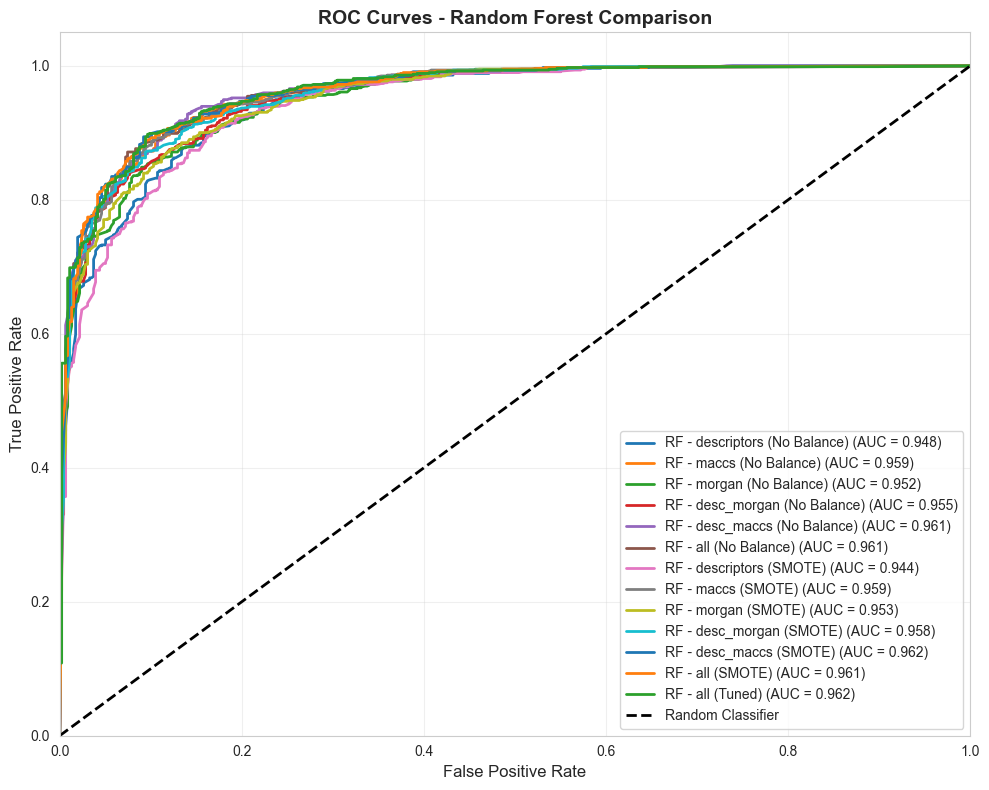

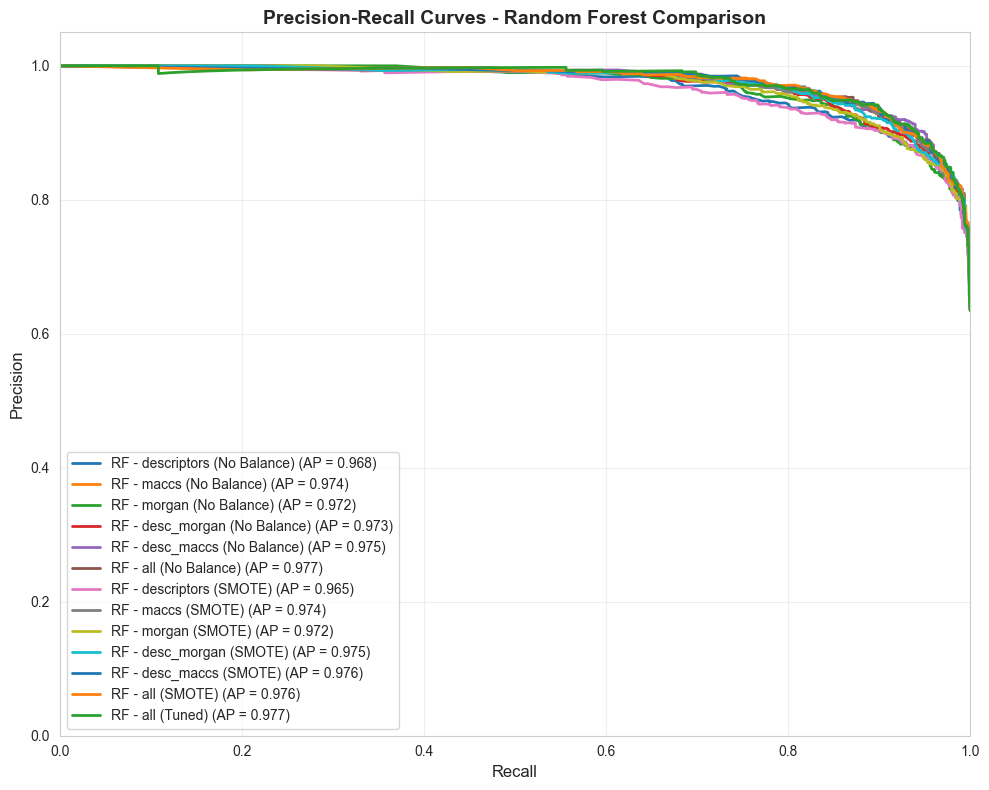

In [71]:
# Plot comparison of RF models
rf_comparison = rf_results_no_balance + rf_results_smote + [results_tuned]
plot_roc_curve(rf_comparison, title="ROC Curves - Random Forest Comparison")
plot_precision_recall_curve(rf_comparison, title="Precision-Recall Curves - Random Forest Comparison")

## Most important features

Here, we have plotted feature importances of top 20 most important features for the random forest model.

As we can see, out of top 20 most important features , most(19) are either molecular descriptors (0-11) or maccs fingerprints bits (12-178).

We have also plotted cumulative feature importance of descriptors + maccs features.

Hence, we can say that molecular descriptors and maccs fingerprints carry most of the information needed for classification.

Number of features in top 20 that are molecular descriptors or maccs fingerprints bits: 19
Top 20 features by importance:


4      0.052513
7      0.038349
3      0.030926
2      0.028800
1      0.023047
0      0.022925
107    0.016103
5      0.013372
20     0.013245
109    0.013230
59     0.011868
9      0.011673
152    0.011325
143    0.011180
23     0.010591
158    0.010113
184    0.009720
135    0.009352
151    0.008564
66     0.007818
dtype: float64

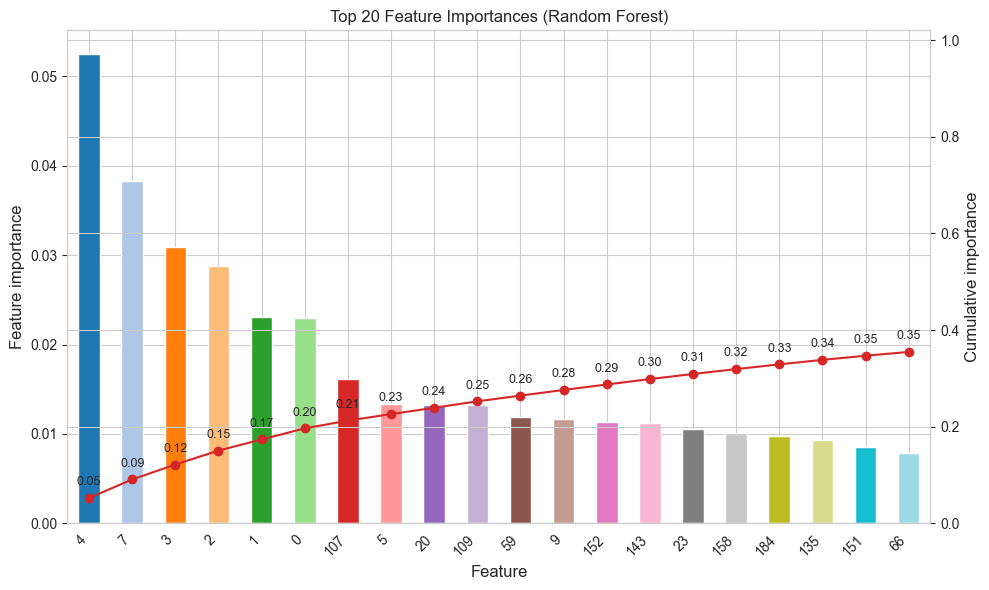

4      0.052513
7      0.038349
3      0.030926
2      0.028800
1      0.023047
0      0.022925
107    0.016103
5      0.013372
20     0.013245
109    0.013230
dtype: float64


Text(0, 0.5, 'Cumulative importance (Descriptors + MACCS)')

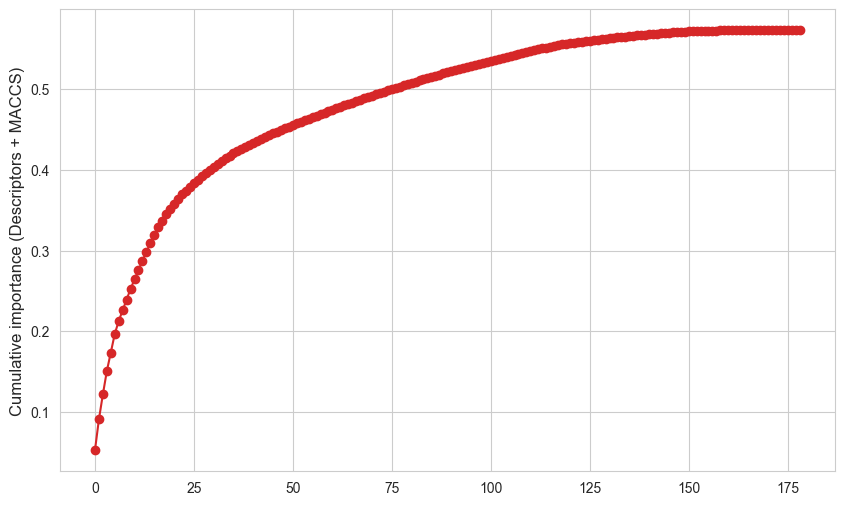

In [72]:
importances = best_rf.feature_importances_

imp_series = pd.Series(importances).sort_values(ascending=False)
top20 = imp_series.head(20)


count = (top20.index < 179).sum()

print(f"Number of features in top 20 that are molecular descriptors or maccs fingerprints bits: {count}")

print('Top 20 features by importance:')
display(top20)

fig, ax1 = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab20(range(len(top20)))
top20.plot(kind='bar', ax=ax1, color=colors)
ax1.set_ylabel('Feature importance', fontsize=12)
ax1.set_xlabel('Feature', fontsize=12)
ax1.set_xticklabels(top20.index, rotation=45, ha='right')
ax1.set_title('Top 20 Feature Importances (Random Forest)')

ax2 = ax1.twinx()
cumulative = top20.cumsum()
ax2.plot(range(len(top20)), cumulative.values, color='C3', marker='o')
ax2.set_ylabel('Cumulative importance', fontsize=12)
ax2.set_ylim(0, 1.02)
for x, y in enumerate(cumulative.values):
    ax2.text(x, y + 0.02, f'{y:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
imp_desc_maccs = imp_series[imp_series.index < 179]
print(imp_desc_maccs.head(10))
cumulative_desc_maccs = imp_desc_maccs.cumsum()
plt.plot(range(len(cumulative_desc_maccs)), cumulative_desc_maccs.values, color='C3', marker='o')
plt.ylabel('Cumulative importance (Descriptors + MACCS)', fontsize=12)

## The most important features correspond to  : 

4      0.054493 - TPSA

7      0.039202 - Num Hetero Atoms

2      0.032575 - Num H Donors

3      0.029578 - Num H acceptors

0      0.023600 - Mol Weight

1      0.022301 - LogP

107    0.017705 - ('[#7]~*~*~[#8]', 0),  # NAAO

20     0.015677 - ('[!#6;!#1]1~*~*~*~1', 0),  # QAAA@1

5      0.013556 - NumRotatableBonds

143    0.013035 - ('[!#6;!#1;!H0]', 1),  # QH > 1 -->any heteroatom (usually Nitrogen, Oxygen, or Sulfur) that is carrying at least one hydrogen atom

## Best RF Model

**AUC Score = 0.965**

Model - RF with input features [morgan + maccs + descriptors]

## 8. XGBoost Experiments

### 8.1 XGBoost with Different Feature Sets

In [73]:
# XGBoost without class imbalance handling
xgb_results_no_balance = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_maccs','desc_morgan', 'all']:
    split = splits[feature_name]
    
    # Create and train model
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )
    
    results = evaluate_model(
        xgb_model,
        split['X_train'], split['X_val'],
        split['y_train'], split['y_val'],
        model_name=f"XGB - {feature_name} (No Balance)",
        eval_set_name="Validation"
    )
    
    xgb_results_no_balance.append(results)
    all_results.append(results)


XGB - descriptors (No Balance) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8647

Precision:
  BBB- (Class 0): 0.8441
  BBB+ (Class 1): 0.8750
  Macro Average: 0.8596
  Weighted Average: 0.8637

Recall:
  BBB- (Class 0): 0.7719
  BBB+ (Class 1): 0.9180
  Macro Average: 0.8450
  Weighted Average: 0.8647

F1-Score:
  BBB- (Class 0): 0.8064
  BBB+ (Class 1): 0.8960
  Macro Average: 0.8512
  Weighted Average: 0.8633

ROC AUC Score: 0.9307
Average Precision Score: 0.9553

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.84      0.77      0.81       456
        BBB+       0.88      0.92      0.90       793

    accuracy                           0.86      1249
   macro avg       0.86      0.84      0.85      1249
weighted avg       0.86      0.86      0.86      1249


XGB - maccs (No Balance) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8871

Precision:
  BBB- (Class 0): 0.8851
  BBB+ (Class 1): 0.8881
  Macro Average

Here, best performing model is one with input representation descriptors + MACCS with AUC of 0.9612

### 8.2 XGBoost with SMOTE

In [74]:
# XGBoost with SMOTE
xgb_results_smote = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_maccs','desc_morgan', 'all']:
    split = splits[feature_name]
    
    # Apply SMOTE to training data
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_balanced, y_train_balanced = smote.fit_resample(split['X_train'], split['y_train'])
    
    # Create and train model
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )
    xgb_model.fit(X_train_balanced, y_train_balanced)
    
    results = evaluate_model(
        xgb_model,
        X_train_balanced, split['X_val'],
        y_train_balanced, split['y_val'],
        model_name=f"XGB - {feature_name} (SMOTE)",
        eval_set_name="Validation"
    )
    
    xgb_results_smote.append(results)
    all_results.append(results)


XGB - descriptors (SMOTE) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8687

Precision:
  BBB- (Class 0): 0.8411
  BBB+ (Class 1): 0.8831
  Macro Average: 0.8621
  Weighted Average: 0.8678

Recall:
  BBB- (Class 0): 0.7895
  BBB+ (Class 1): 0.9142
  Macro Average: 0.8519
  Weighted Average: 0.8687

F1-Score:
  BBB- (Class 0): 0.8145
  BBB+ (Class 1): 0.8984
  Macro Average: 0.8564
  Weighted Average: 0.8678

ROC AUC Score: 0.9332
Average Precision Score: 0.9574

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.84      0.79      0.81       456
        BBB+       0.88      0.91      0.90       793

    accuracy                           0.87      1249
   macro avg       0.86      0.85      0.86      1249
weighted avg       0.87      0.87      0.87      1249


XGB - maccs (SMOTE) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8783

Precision:
  BBB- (Class 0): 0.8671
  BBB+ (Class 1): 0.8838
  Macro Average: 0.8755
 

SMOTE doesn't improve results noticeably for any of the models (similar results to logistic regression and random forests).

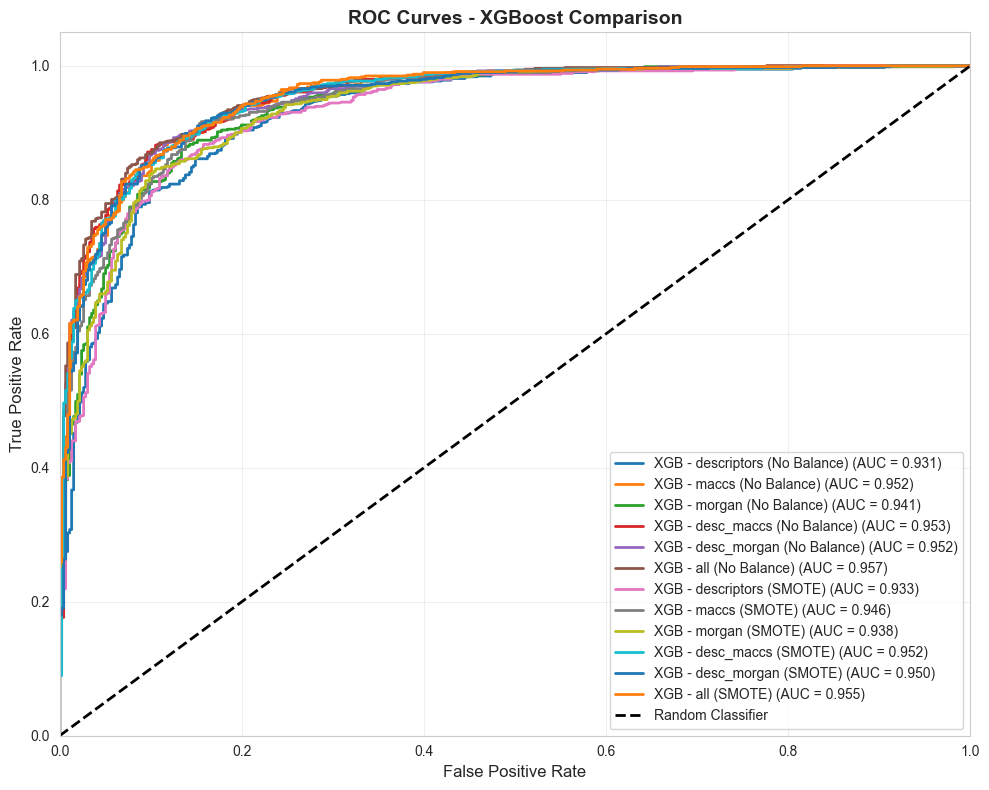

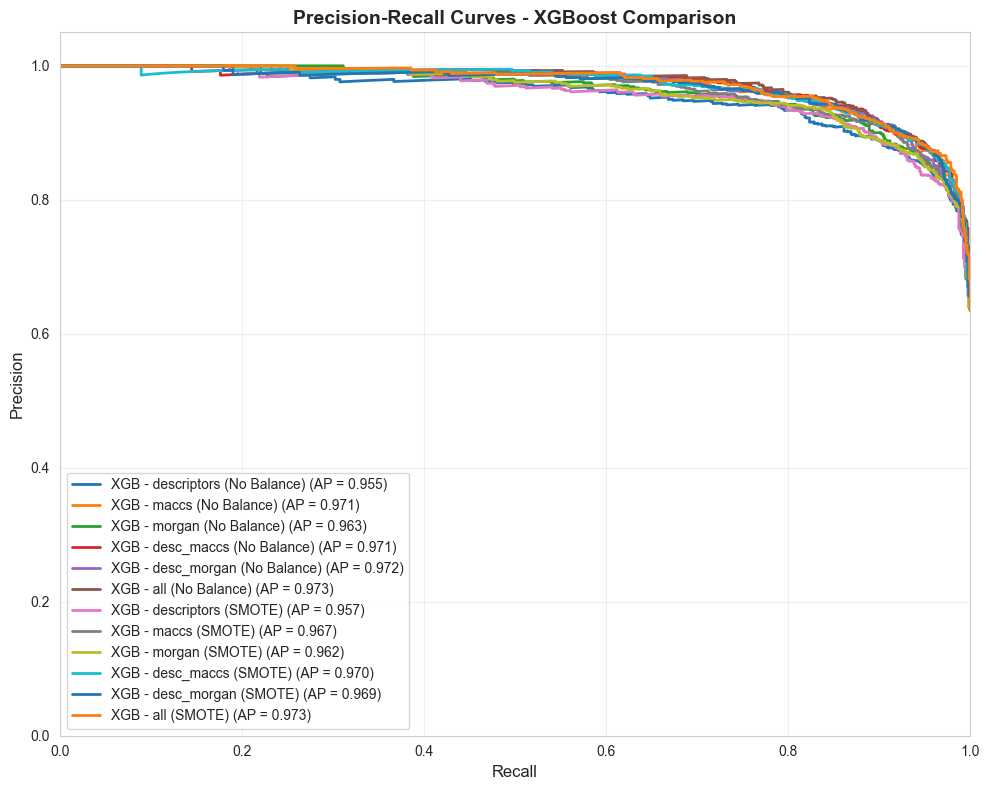

In [75]:
# Plot XGBoost comparison
xgb_comparison = xgb_results_no_balance + xgb_results_smote
plot_roc_curve(xgb_comparison, title="ROC Curves - XGBoost Comparison")
plot_precision_recall_curve(xgb_comparison, title="Precision-Recall Curves - XGBoost Comparison")

## Best XGBoost Model : 

**AUC Score = 0.961**

Model - input descirptors + MACCS

## 9. Ensemble Methods

Combining multiple models for improved performance

### 9.1 Voting Classifier (Soft Voting)

In [76]:
# Voting Classifier with best models from each type
# Using 'all' features

split = splits['all']

# Define base estimators
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, 
                            use_label_encoder=False, eval_metric='logloss', n_jobs=-1)

# Create voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb_clf)],
    voting='soft'
)

print("Training Voting Classifier...")
results_voting = evaluate_model(
    voting_clf,
    split['X_train'], split['X_val'],
    split['y_train'], split['y_val'],
    model_name="Voting Ensemble (LR+RF+XGB, imbalanced)",
    eval_set_name="Validation"
)

all_results.append(results_voting)

Training Voting Classifier...



Voting Ensemble (LR+RF+XGB, imbalanced) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8879

Precision:
  BBB- (Class 0): 0.8950
  BBB+ (Class 1): 0.8846
  Macro Average: 0.8898
  Weighted Average: 0.8884

Recall:
  BBB- (Class 0): 0.7851
  BBB+ (Class 1): 0.9470
  Macro Average: 0.8661
  Weighted Average: 0.8879

F1-Score:
  BBB- (Class 0): 0.8364
  BBB+ (Class 1): 0.9147
  Macro Average: 0.8756
  Weighted Average: 0.8862

ROC AUC Score: 0.9601
Average Precision Score: 0.9771

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.90      0.79      0.84       456
        BBB+       0.88      0.95      0.91       793

    accuracy                           0.89      1249
   macro avg       0.89      0.87      0.88      1249
weighted avg       0.89      0.89      0.89      1249



AUC Score of (Soft)Voting Classifier = 0.9643

### 9.2 Stacking Classifier

In [77]:
# Stacking Classifier
# Base models: LR, RF, XGB
# Meta-model: Logistic Regression

base_estimators = [
    ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, 
                              use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
]

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

print("Training Stacking Classifier...")
results_stacking = evaluate_model(
    stacking_clf,
    split['X_train'], split['X_val'],
    split['y_train'], split['y_val'],
    model_name="Stacking Ensemble (LR+RF+XGB, imbalanced)",
    eval_set_name="Validation"
)

all_results.append(results_stacking)

Training Stacking Classifier...

Stacking Ensemble (LR+RF+XGB, imbalanced) - Validation Set Results

Overall Metrics:
  Accuracy: 0.8903

Precision:
  BBB- (Class 0): 0.8997
  BBB+ (Class 1): 0.8859
  Macro Average: 0.8928
  Weighted Average: 0.8909

Recall:
  BBB- (Class 0): 0.7873
  BBB+ (Class 1): 0.9496
  Macro Average: 0.8684
  Weighted Average: 0.8903

F1-Score:
  BBB- (Class 0): 0.8398
  BBB+ (Class 1): 0.9166
  Macro Average: 0.8782
  Weighted Average: 0.8886

ROC AUC Score: 0.9634
Average Precision Score: 0.9790

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.90      0.79      0.84       456
        BBB+       0.89      0.95      0.92       793

    accuracy                           0.89      1249
   macro avg       0.89      0.87      0.88      1249
weighted avg       0.89      0.89      0.89      1249



**AUC Score of Meta-Model = 0.9661**
This is best AUC achieved so far.

## 10. Validation Set Comparison

### 10.1 Compare All Models on Validation Set

In [78]:
comparison_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Accuracy': r['accuracy'],
        'Precision (BBB-)': r['precision_class_0'],
        'Precision (BBB+)': r['precision_class_1'],
        'Recall (BBB-)': r['recall_class_0'],
        'Recall (BBB+)': r['recall_class_1'],
        'F1 (BBB-)': r['f1_class_0'],
        'F1 (BBB+)': r['f1_class_1'],
        'F1 Macro': r['f1_macro'],
        'ROC AUC': r['roc_auc'] if r['roc_auc'] else 0
    }
    for r in all_results
])

comparison_df = comparison_df.sort_values('ROC AUC', ascending=False)

print("="*100)
print("VALIDATION SET PERFORMANCE - ALL MODELS")
print("="*100)

print(comparison_df.to_string(index=False))

comparison_df.to_csv('../figures/ml_methods/model_comparison_validation.csv', index=False)
print("\nValidation results saved to '../figures/ml_methods/model_comparison_validation.csv'")

VALIDATION SET PERFORMANCE - ALL MODELS
                                    Model  Accuracy  Precision (BBB-)  Precision (BBB+)  Recall (BBB-)  Recall (BBB+)  F1 (BBB-)  F1 (BBB+)  F1 Macro  ROC AUC
Stacking Ensemble (LR+RF+XGB, imbalanced)  0.890312          0.899749          0.885882       0.787281       0.949559   0.839766   0.916616  0.878191 0.963359
                         RF - all (Tuned)  0.884708          0.923913          0.868331       0.745614       0.964691   0.825243   0.913978  0.869611 0.962238
                  RF - desc_maccs (SMOTE)  0.892714          0.896552          0.890866       0.798246       0.947037   0.844548   0.918093  0.881320 0.961822
                    RF - all (No Balance)  0.884708          0.914894          0.871707       0.754386       0.959647   0.826923   0.913565  0.870244 0.961450
                         RF - all (SMOTE)  0.888711          0.901266          0.882904       0.780702       0.950820   0.836663   0.915604  0.876133 0.961397
      

### 10.2 Visualize Top Performing Models (Validation Set)

### 10.2 Visualize Top Performing Models

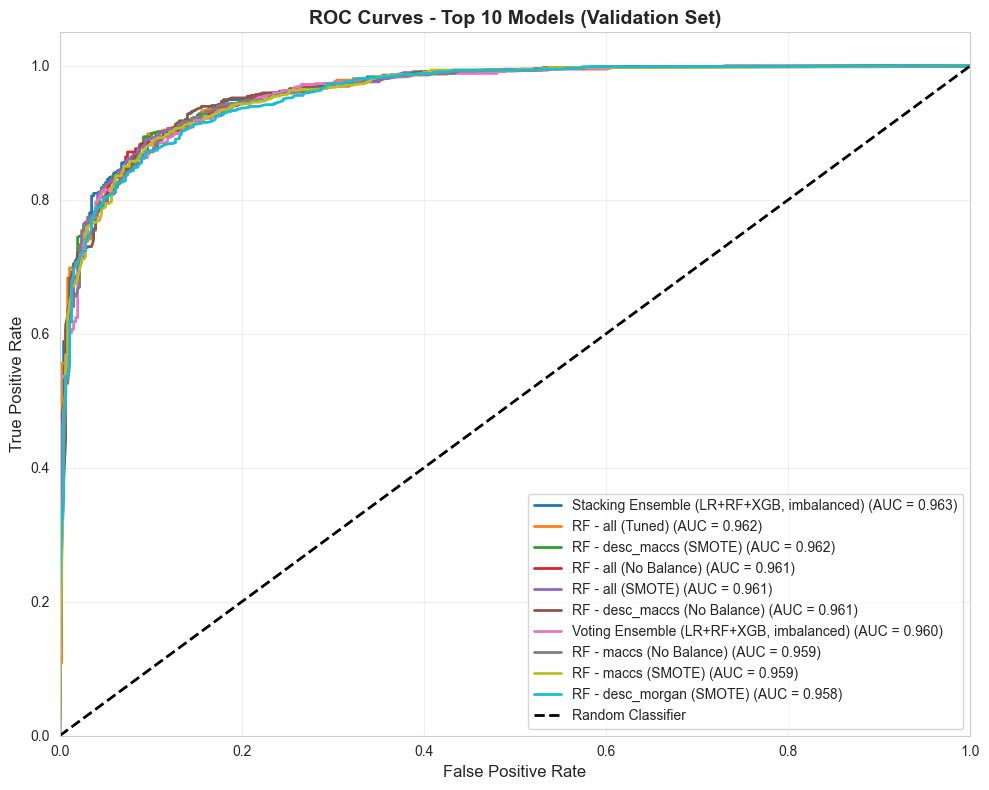

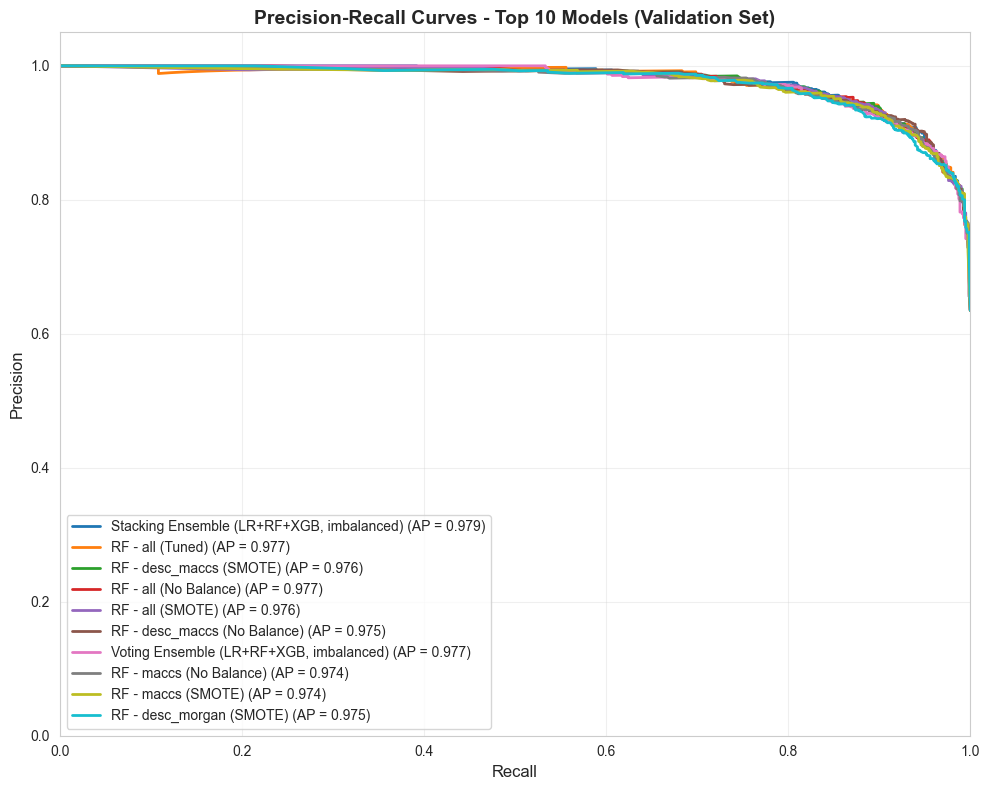

In [79]:
top_10_models = [r for r in sorted(all_results, key=lambda x: x['roc_auc'] if x['roc_auc'] else 0, reverse=True)[:10]]

plot_roc_curve(top_10_models, title="ROC Curves - Top 10 Models (Validation Set)")
plot_precision_recall_curve(top_10_models, title="Precision-Recall Curves - Top 10 Models (Validation Set)")

### 10.3 Class Imbalance Treatment Comparison (Validation Set)

Compare performance with and without class imbalance handling

IMPACT OF CLASS IMBALANCE HANDLING (SMOTE)
              Model  No Balance - Accuracy  SMOTE - Accuracy  No Balance - ROC AUC  SMOTE - ROC AUC  No Balance - F1 (BBB+)  SMOTE - F1 (BBB+)
Logistic Regression               0.865492          0.863891              0.913482         0.911121                0.895782           0.892677
      Random Forest               0.884708          0.888711              0.961450         0.961397                0.913565           0.915604
            XGBoost               0.889512          0.889512              0.956554         0.954928                0.915337           0.915545


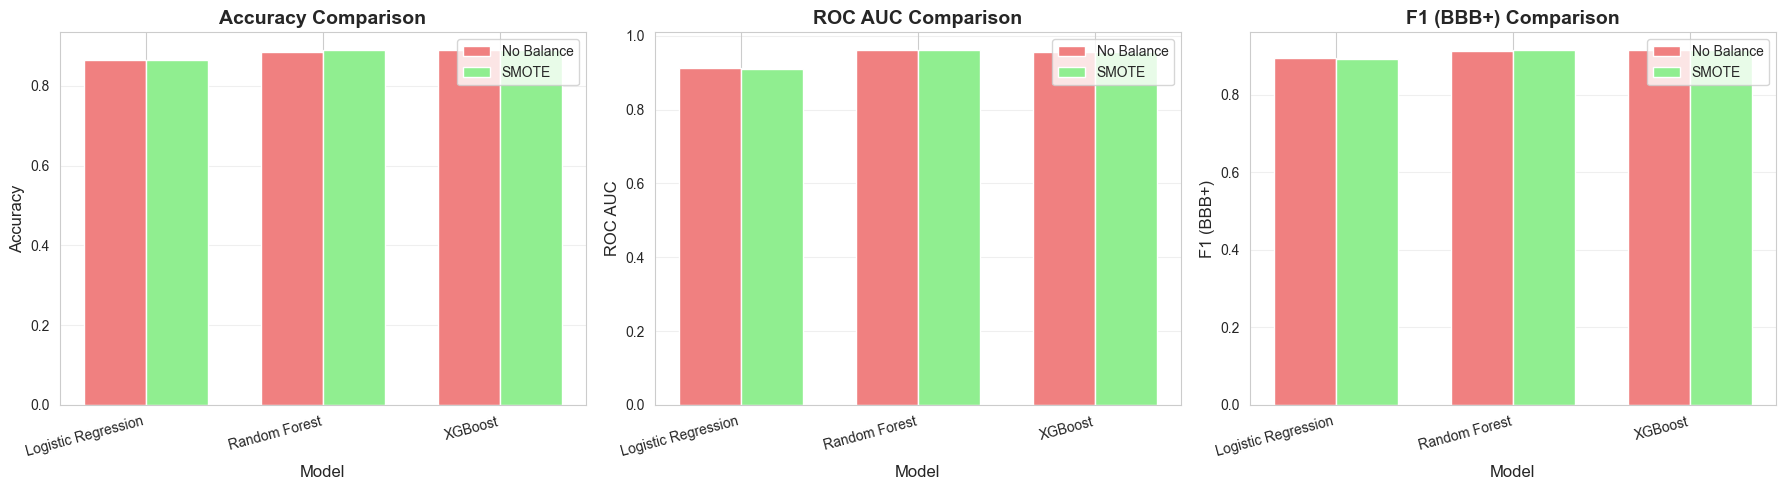

In [80]:

print("IMPACT OF CLASS IMBALANCE HANDLING (SMOTE)")

lr_no_balance = [r for r in lr_results_no_balance if 'all' in r['model_name']][0]
lr_smote = [r for r in lr_results_smote if 'all' in r['model_name']][0]
rf_no_balance = [r for r in rf_results_no_balance if 'all' in r['model_name']][0]
rf_smote = [r for r in rf_results_smote if 'all' in r['model_name']][0]
xgb_no_balance = [r for r in xgb_results_no_balance if 'all' in r['model_name']][0]
xgb_smote = [r for r in xgb_results_smote if 'all' in r['model_name']][0]

imbalance_comparison = pd.DataFrame([
    {
        'Model': 'Logistic Regression',
        'No Balance - Accuracy': lr_no_balance['accuracy'],
        'SMOTE - Accuracy': lr_smote['accuracy'],
        'No Balance - ROC AUC': lr_no_balance['roc_auc'],
        'SMOTE - ROC AUC': lr_smote['roc_auc'],
        'No Balance - F1 (BBB+)': lr_no_balance['f1_class_1'],
        'SMOTE - F1 (BBB+)': lr_smote['f1_class_1']
    },
    {
        'Model': 'Random Forest',
        'No Balance - Accuracy': rf_no_balance['accuracy'],
        'SMOTE - Accuracy': rf_smote['accuracy'],
        'No Balance - ROC AUC': rf_no_balance['roc_auc'],
        'SMOTE - ROC AUC': rf_smote['roc_auc'],
        'No Balance - F1 (BBB+)': rf_no_balance['f1_class_1'],
        'SMOTE - F1 (BBB+)': rf_smote['f1_class_1']
    },
    {
        'Model': 'XGBoost',
        'No Balance - Accuracy': xgb_no_balance['accuracy'],
        'SMOTE - Accuracy': xgb_smote['accuracy'],
        'No Balance - ROC AUC': xgb_no_balance['roc_auc'],
        'SMOTE - ROC AUC': xgb_smote['roc_auc'],
        'No Balance - F1 (BBB+)': xgb_no_balance['f1_class_1'],
        'SMOTE - F1 (BBB+)': xgb_smote['f1_class_1']
    }
])

print(imbalance_comparison.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Accuracy', 'ROC AUC', 'F1 (BBB+)']
for idx, metric in enumerate(metrics):
    no_balance_col = f'No Balance - {metric}'
    smote_col = f'SMOTE - {metric}'
    
    x = np.arange(len(imbalance_comparison))
    width = 0.35
    
    axes[idx].bar(x - width/2, imbalance_comparison[no_balance_col], width, 
                  label='No Balance', color='lightcoral')
    axes[idx].bar(x + width/2, imbalance_comparison[smote_col], width, 
                  label='SMOTE', color='lightgreen')
    
    axes[idx].set_xlabel('Model', fontsize=12)
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(imbalance_comparison['Model'], rotation=15, ha='right')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/ml_methods/imbalance_treatment_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


From above plot, we can conclude that SMOTE did not greatly improve performance of the classifier. 

This could be because we are using high dimensional relatively sparse data, for which SMOTE does not perform as well.

## 11. Final Evaluation on Test Set

Now that we've selected the best models based on validation performance, let's evaluate them on the held-out test set to get unbiased performance estimates.

TOP 10 MODELS BASED ON VALIDATION PERFORMANCE
1. Stacking Ensemble (LR+RF+XGB, imbalanced): ROC AUC = 0.9634
2. RF - all (Tuned): ROC AUC = 0.9622
3. RF - desc_maccs (SMOTE): ROC AUC = 0.9618
4. RF - all (No Balance): ROC AUC = 0.9614
5. RF - all (SMOTE): ROC AUC = 0.9614
6. RF - desc_maccs (No Balance): ROC AUC = 0.9612
7. Voting Ensemble (LR+RF+XGB, imbalanced): ROC AUC = 0.9601
8. RF - maccs (No Balance): ROC AUC = 0.9594
9. RF - maccs (SMOTE): ROC AUC = 0.9593
10. RF - desc_morgan (SMOTE): ROC AUC = 0.9582

EVALUATING TOP MODELS ON TEST SET

Stacking Ensemble (LR+RF+XGB, imbalanced)
  Validation ROC AUC: 0.9634
  Test ROC AUC: 0.9607
  Test Accuracy: 0.8930
  Test F1 Macro: 0.8823

RF - all (Tuned)
  Validation ROC AUC: 0.9622
  Test ROC AUC: 0.9608
  Test Accuracy: 0.8764
  Test F1 Macro: 0.8615

RF - desc_maccs (SMOTE)
  Validation ROC AUC: 0.9618
  Test ROC AUC: 0.9598
  Test Accuracy: 0.8866
  Test F1 Macro: 0.8752

RF - all (No Balance)
  Validation ROC AUC: 0.9614
  Test ROC 

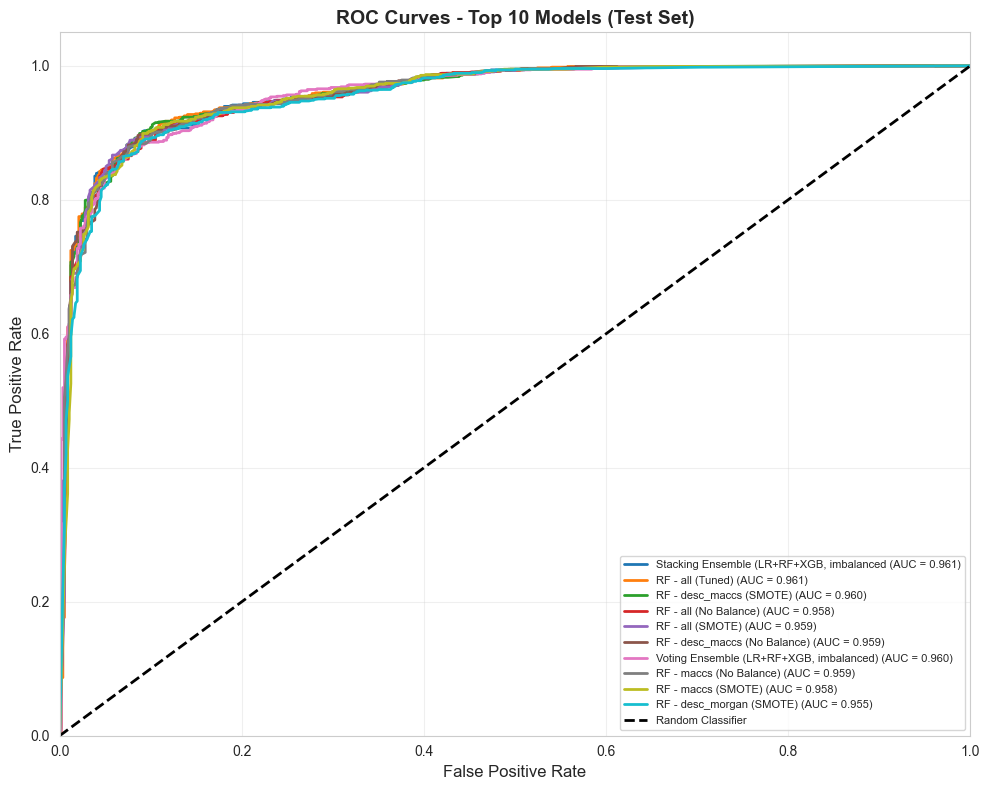

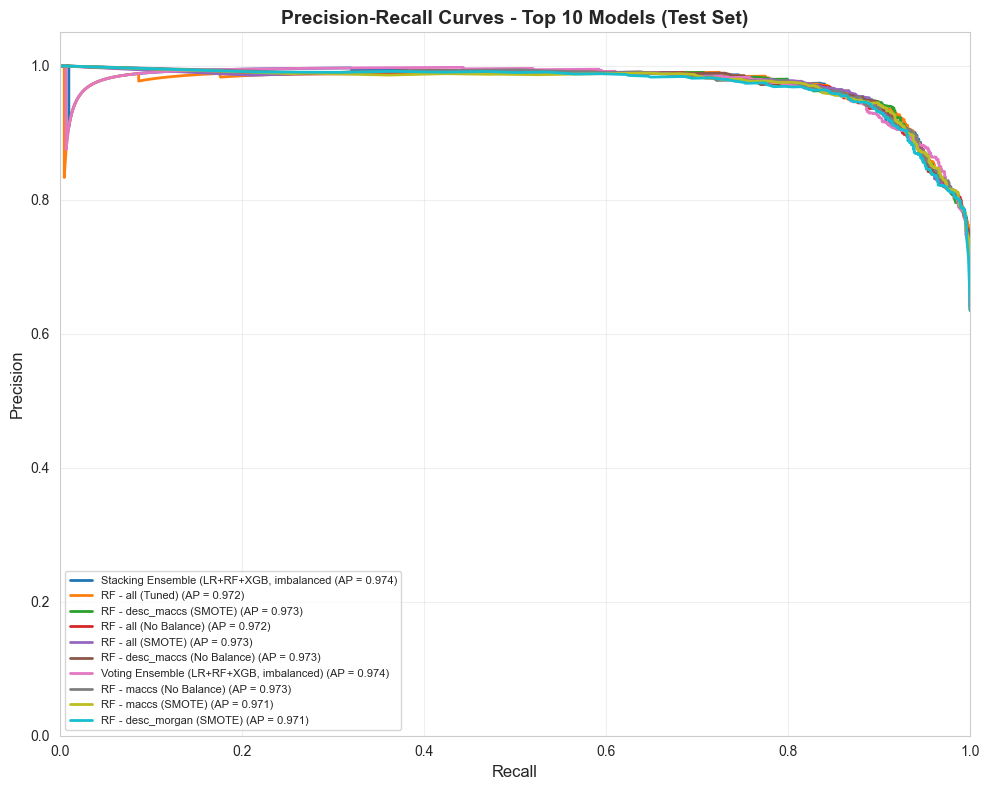

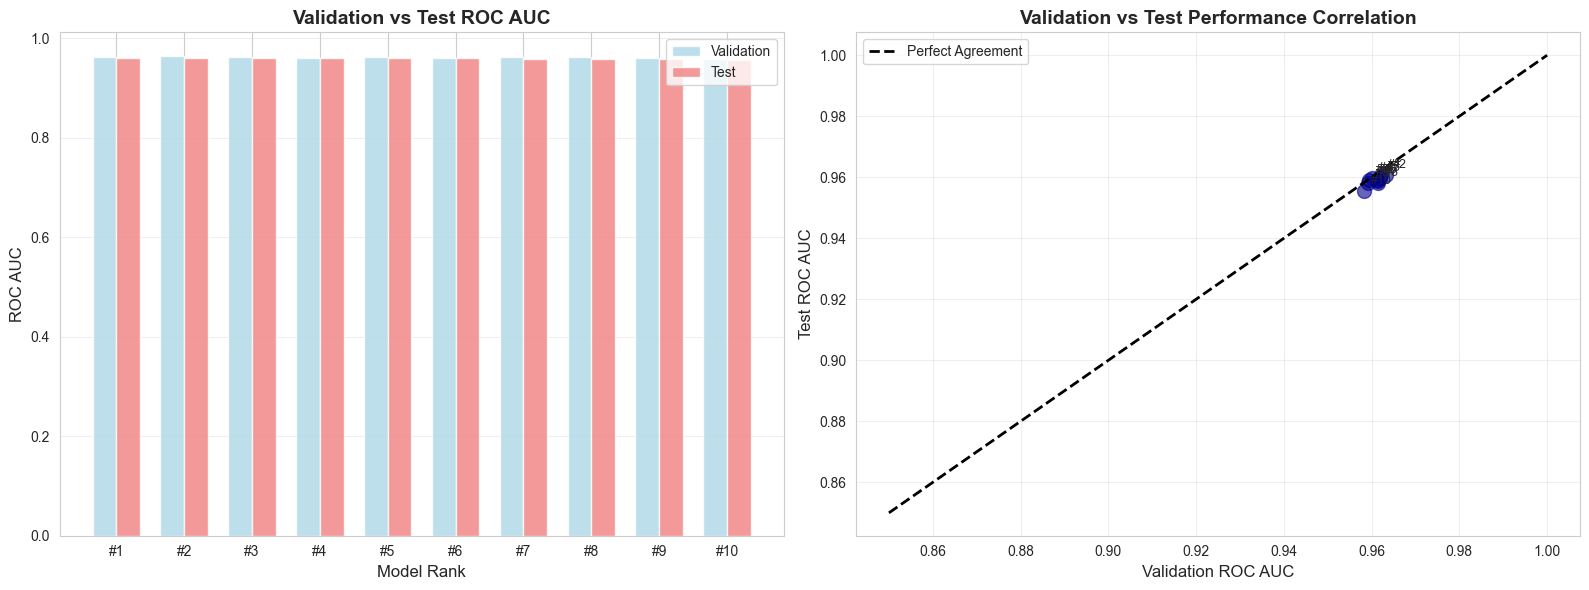


BEST MODEL - TEST SET PERFORMANCE

Model: Stacking Ensemble (LR+RF+XGB, imbalanced)

Validation Performance:
  ROC AUC: 0.9634

Test Performance:
  ROC AUC: 0.9607
  Accuracy: 0.8930
  Precision (BBB-): 0.8882
  Precision (BBB+): 0.8954
  Recall (BBB-): 0.8088
  Recall (BBB+): 0.9415
  F1 (BBB-): 0.8466
  F1 (BBB+): 0.9179
  F1 Macro: 0.8823
  Average Precision: 0.9742


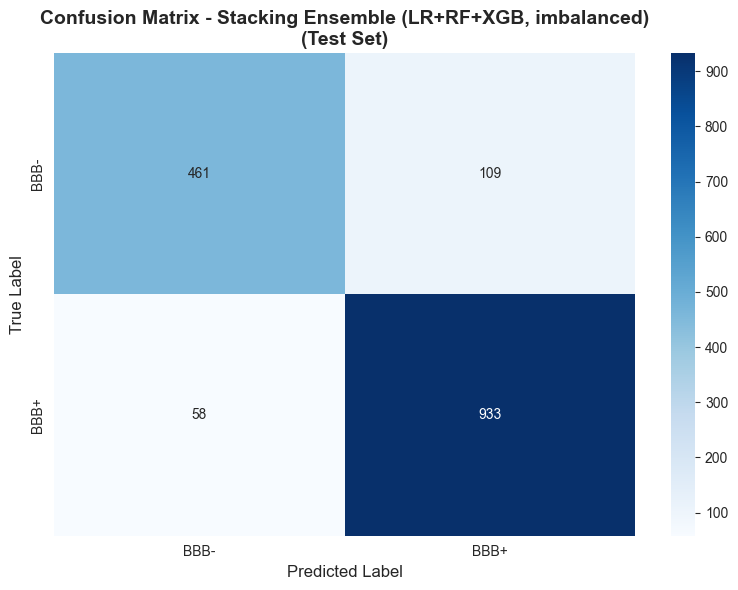


Classification Report (Test Set):
              precision    recall  f1-score   support

        BBB-       0.89      0.81      0.85       570
        BBB+       0.90      0.94      0.92       991

    accuracy                           0.89      1561
   macro avg       0.89      0.88      0.88      1561
weighted avg       0.89      0.89      0.89      1561


EXPERIMENTS SUMMARY

Dataset Split:
  - Training: 64% (4995 samples)
  - Validation: 16% (1249 samples)
  - Test: 20% (1561 samples)

Total models evaluated: 57

Best model on validation set: Stacking Ensemble (LR+RF+XGB, imbalanced)
   - Validation ROC AUC: 0.9634
   - Validation Accuracy: 0.8903
   - Validation F1 Macro: 0.8782

Best model on test set: RF - all (Tuned)
   - Test ROC AUC: 0.9608
   - Test Accuracy: 0.8764
   - Test F1 Macro: 0.8615
   - Test Precision (BBB+): 0.8688
   - Test Recall (BBB+): 0.9485
   - Test Precision (BBB-): 0.8935
   - Test Recall (BBB-): 0.7509

KEY FINDINGS

1. Feature Representations:
   - C

In [84]:

# Select top 10 models based on validation ROC AUC
top_models_for_test = sorted(all_results, key=lambda x: x['roc_auc'] if x['roc_auc'] else 0, reverse=True)[:10]

print("TOP 10 MODELS BASED ON VALIDATION PERFORMANCE")
print("="*80)
for i, model in enumerate(top_models_for_test, 1):
    print(f"{i}. {model['model_name']}: ROC AUC = {model['roc_auc']:.4f}")
print("="*80)

test_results = []

print("\n" + "="*80)
print("EVALUATING TOP MODELS ON TEST SET")
print("="*80)

for model_result in top_models_for_test:
    model = model_result['model']
    model_name = model_result['model_name']
    
    feature_name = None
    for fname in ['desc_morgan', 'desc_maccs', 'descriptors', 'maccs', 'morgan', 'all']:
        if fname in model_name.lower():
            feature_name = fname
            break
    # print(f"model_name: {model_name}, feature_name: {feature_name}")
    
    if feature_name is None:
        feature_name = 'all'
    
    split = splits[feature_name]
    
    y_test_pred = model.predict(split['X_test'])
    y_test_pred_proba = model.predict_proba(split['X_test'])[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(split['y_test'], y_test_pred)
    precision_per_class = precision_score(split['y_test'], y_test_pred, average=None)
    recall_per_class = recall_score(split['y_test'], y_test_pred, average=None)
    f1_per_class = f1_score(split['y_test'], y_test_pred, average=None)
    precision_macro = precision_score(split['y_test'], y_test_pred, average='macro')
    recall_macro = recall_score(split['y_test'], y_test_pred, average='macro')
    f1_macro = f1_score(split['y_test'], y_test_pred, average='macro')
    
    if y_test_pred_proba is not None:
        roc_auc = roc_auc_score(split['y_test'], y_test_pred_proba)
        avg_precision = average_precision_score(split['y_test'], y_test_pred_proba)
    else:
        roc_auc = None
        avg_precision = None
    
    test_result = {
        'model_name': model_name,
        'val_roc_auc': model_result['roc_auc'],
        'test_accuracy': accuracy,
        'test_precision_class_0': precision_per_class[0],
        'test_precision_class_1': precision_per_class[1],
        'test_precision_macro': precision_macro,
        'test_recall_class_0': recall_per_class[0],
        'test_recall_class_1': recall_per_class[1],
        'test_recall_macro': recall_macro,
        'test_f1_class_0': f1_per_class[0],
        'test_f1_class_1': f1_per_class[1],
        'test_f1_macro': f1_macro,
        'test_roc_auc': roc_auc,
        'test_avg_precision': avg_precision,
        'y_test': split['y_test'],
        'y_test_pred': y_test_pred,
        'y_test_pred_proba': y_test_pred_proba
    }
    
    test_results.append(test_result)
    
    print(f"\n{model_name}")
    print(f"  Validation ROC AUC: {model_result['roc_auc']:.4f}")
    print(f"  Test ROC AUC: {roc_auc:.4f}")
    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  Test F1 Macro: {f1_macro:.4f}")

print("\n" + "="*80)

test_comparison_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Val ROC AUC': r['val_roc_auc'],
        'Test ROC AUC': r['test_roc_auc'],
        'Test Accuracy': r['test_accuracy'],
        'Test Precision (BBB-)': r['test_precision_class_0'],
        'Test Precision (BBB+)': r['test_precision_class_1'],
        'Test Recall (BBB-)': r['test_recall_class_0'],
        'Test Recall (BBB+)': r['test_recall_class_1'],
        'Test F1 (BBB-)': r['test_f1_class_0'],
        'Test F1 (BBB+)': r['test_f1_class_1'],
        'Test F1 Macro': r['test_f1_macro']
    }
    for r in test_results
])

test_comparison_df = test_comparison_df.sort_values('Test ROC AUC', ascending=False)

print("\n" + "="*120)
print("TEST SET PERFORMANCE - TOP 10 MODELS")
print("="*120)
print(test_comparison_df.to_string(index=False))
print("="*120)

test_comparison_df.to_csv('../figures/ml_methods/model_comparison_test.csv', index=False)
print("\nTest results saved to '../figures/ml_methods/model_comparison_test.csv'")

# Plot ROC curves for test set
plt.figure(figsize=(10, 8))

for result in test_results:
    if result['y_test_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(result['y_test'], result['y_test_pred_proba'])
        roc_auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{result['model_name'][:40]} (AUC = {roc_auc_val:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Top 10 Models (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/ml_methods/roc_curves_test_set.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot Precision-Recall curves for test set
plt.figure(figsize=(10, 8))

for result in test_results:
    if result['y_test_pred_proba'] is not None:
        precision, recall, _ = precision_recall_curve(result['y_test'], result['y_test_pred_proba'])
        avg_precision = average_precision_score(result['y_test'], result['y_test_pred_proba'])
        plt.plot(recall, precision, lw=2, label=f"{result['model_name'][:40]} (AP = {avg_precision:.3f})")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Top 10 Models (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc="best", fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/ml_methods/pr_curves_test_set.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare validation vs test performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

val_aucs = test_comparison_df['Val ROC AUC'].values
test_aucs = test_comparison_df['Test ROC AUC'].values
model_indices = np.arange(len(test_comparison_df))

width = 0.35
axes[0].bar(model_indices - width/2, val_aucs, width, label='Validation', color='lightblue', alpha=0.8)
axes[0].bar(model_indices + width/2, test_aucs, width, label='Test', color='lightcoral', alpha=0.8)
axes[0].set_xlabel('Model Rank', fontsize=12)
axes[0].set_ylabel('ROC AUC', fontsize=12)
axes[0].set_title('Validation vs Test ROC AUC', fontsize=14, fontweight='bold')
axes[0].set_xticks(model_indices)
axes[0].set_xticklabels([f'#{i+1}' for i in model_indices])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].scatter(val_aucs, test_aucs, s=100, alpha=0.6, color='darkblue')
axes[1].plot([0.85, 1.0], [0.85, 1.0], 'k--', lw=2, label='Perfect Agreement')
axes[1].set_xlabel('Validation ROC AUC', fontsize=12)
axes[1].set_ylabel('Test ROC AUC', fontsize=12)
axes[1].set_title('Validation vs Test Performance Correlation', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

for i, (val, test) in enumerate(zip(val_aucs, test_aucs)):
    axes[1].annotate(f'#{i+1}', (val, test), xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.savefig('../figures/ml_methods/validation_vs_test_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

best_test_model = test_results[0]

print("\n" + "="*80)
print("BEST MODEL - TEST SET PERFORMANCE")
print("="*80)
print(f"\nModel: {best_test_model['model_name']}")
print(f"\nValidation Performance:")
print(f"  ROC AUC: {best_test_model['val_roc_auc']:.4f}")
print(f"\nTest Performance:")
print(f"  ROC AUC: {best_test_model['test_roc_auc']:.4f}")
print(f"  Accuracy: {best_test_model['test_accuracy']:.4f}")
print(f"  Precision (BBB-): {best_test_model['test_precision_class_0']:.4f}")
print(f"  Precision (BBB+): {best_test_model['test_precision_class_1']:.4f}")
print(f"  Recall (BBB-): {best_test_model['test_recall_class_0']:.4f}")
print(f"  Recall (BBB+): {best_test_model['test_recall_class_1']:.4f}")
print(f"  F1 (BBB-): {best_test_model['test_f1_class_0']:.4f}")
print(f"  F1 (BBB+): {best_test_model['test_f1_class_1']:.4f}")
print(f"  F1 Macro: {best_test_model['test_f1_macro']:.4f}")
print(f"  Average Precision: {best_test_model['test_avg_precision']:.4f}")

cm = confusion_matrix(best_test_model['y_test'], best_test_model['y_test_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['BBB-', 'BBB+'], 
            yticklabels=['BBB-', 'BBB+'])
plt.title(f'Confusion Matrix - {best_test_model["model_name"]}\n(Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('../figures/ml_methods/confusion_matrix_best_model_test.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nClassification Report (Test Set):")
print(classification_report(best_test_model['y_test'], best_test_model['y_test_pred'], 
                          target_names=['BBB-', 'BBB+']))
print("="*80)

best_model_val = comparison_df.iloc[0]

print("\n" + "="*100)
print("EXPERIMENTS SUMMARY")
print("="*100)
print(f"\nDataset Split:")
print(f"  - Training: 64% ({len(splits['all']['y_train'])} samples)")
print(f"  - Validation: 16% ({len(splits['all']['y_val'])} samples)")
print(f"  - Test: 20% ({len(splits['all']['y_test'])} samples)")

print(f"\nTotal models evaluated: {len(all_results)}")

print(f"\nBest model on validation set: {best_model_val['Model']}")
print(f"   - Validation ROC AUC: {best_model_val['ROC AUC']:.4f}")
print(f"   - Validation Accuracy: {best_model_val['Accuracy']:.4f}")
print(f"   - Validation F1 Macro: {best_model_val['F1 Macro']:.4f}")

best_test_row = test_comparison_df.iloc[0]
print(f"\nBest model on test set: {best_test_row['Model']}")
print(f"   - Test ROC AUC: {best_test_row['Test ROC AUC']:.4f}")
print(f"   - Test Accuracy: {best_test_row['Test Accuracy']:.4f}")
print(f"   - Test F1 Macro: {best_test_row['Test F1 Macro']:.4f}")
print(f"   - Test Precision (BBB+): {best_test_row['Test Precision (BBB+)']:.4f}")
print(f"   - Test Recall (BBB+): {best_test_row['Test Recall (BBB+)']:.4f}")
print(f"   - Test Precision (BBB-): {best_test_row['Test Precision (BBB-)']:.4f}")
print(f"   - Test Recall (BBB-): {best_test_row['Test Recall (BBB-)']:.4f}")

print(f"\n" + "="*100)
print("KEY FINDINGS")
print("="*100)

print(f"\n1. Feature Representations:")
print(f"   - Combined features (descriptors + fingerprints) generally perform better")
print(f"   - Morgan fingerprints tend to perform well with LR")
print(f"   - MACCS fingerprints work well with tree-based models (RF, XGB)")
print(f"   - Best overall: Combined features (descriptors + MACCS + Morgan)")

print(f"\n2. Class Imbalance Handling:")
print(f"   - SMOTE and class weighting showed limited improvement")
print(f"   - In some cases, these techniques slightly reduced performance")
print(f"   - Tree-based models handle imbalance well without special treatment")
print(f"   - This suggests collecting more minority class data is more valuable")

# Count model types in top 10
lr_count = sum(1 for r in top_models_for_test if r['model_name'].startswith('LR'))
rf_count = sum(1 for r in top_models_for_test if r['model_name'].startswith('RF'))
xgb_count = sum(1 for r in top_models_for_test if r['model_name'].startswith('XGB'))
ensemble_count = sum(1 for r in top_models_for_test if 'Ensemble' in r['model_name'])

print(f"\n3. Model Types (in top 10 on validation):")
print(f"   - Logistic Regression: {lr_count}")
print(f"   - Random Forest: {rf_count}")
print(f"   - XGBoost: {xgb_count}")
print(f"   - Ensemble: {ensemble_count}")
print(f"   - Random Forest models dominate, showing effectiveness for this task")

print(f"\n4. Dimensionality Reduction (PCA):")
print(f"   - PCA helped with high-dimensional sparse features (Morgan fingerprints)")
print(f"   - Led to worse performance on denser representations")
print(f"   - Suggests PCA is most useful for very high-dimensional inputs")

print(f"\n6. Final Recommendations:")
print(f"   - Best model: {best_test_row['Model']}")
print(f"   - Use combined feature representations for best performance")
print(f"   - Random Forest and ensemble methods are most reliable")
print(f"   - Proper train/val/test split prevents overly optimistic estimates")
print(f"   - Hold out test set strictly for final evaluation")

print("\n" + "="*100)